# Carga de paquetes

In [1]:
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import  DataLoader, ConcatDataset

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os
import pylab as pl
from IPython import display
import nibabel
from preprocessing import * 

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CARGA DE DATOS

In [2]:
BASE_PATH = os.getcwd() + "\\data"
TRAINING_PATH_AMSTERDAM= BASE_PATH + "\\training\\Amsterdam\\GE3T\\"
TRAINING_PATH_SINGAPORE= BASE_PATH + "\\training\\Singapore\\"
TRAINING_PATH_UTRECHT= BASE_PATH + "\\training\\Utrecht\\"

TEST_PATH_AMSTERDAM= BASE_PATH + "\\test\\Amsterdam\\"
TEST_PATH_SINGAPORE= BASE_PATH + "\\test\\Singapore\\"
TEST_PATH_UTRECHT= BASE_PATH + "\\test\\Utrecht\\"

# DICCIONARIO TRAINING Y TEST

In [3]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[],
    "ID":[]
}
createDictionary(TRAINING_PATH_UTRECHT, TRAINING_DICT,"Utrecht")
createDictionary(TRAINING_PATH_SINGAPORE, TRAINING_DICT, "Singapore")
createDictionary(TRAINING_PATH_AMSTERDAM, TRAINING_DICT,"Amsterdam")

In [4]:
TEST_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[],
    "ID":[]
}
createDictionary(TEST_PATH_UTRECHT, TEST_DICT,"Utrecht")
createDictionary(TEST_PATH_SINGAPORE, TEST_DICT,"Singapore")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE1T5"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE3T"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "Philips_VU .PETMR_01"), TEST_DICT,"Amsterdam")

# Crear dataset entrenamiento y test

In [5]:
train,val=divideDataset(TRAINING_DICT,0.8)
print("total training FLAIR images", len(train.__getitem__("pathsFLAIR")))
print("total test FLAIR images", len(val.__getitem__("pathsFLAIR")))

total training FLAIR images 48
total test FLAIR images 12


In [5]:
train,val=getIDs(TRAINING_DICT)
print("total training FLAIR images", len(train.__getitem__("pathsFLAIR")))
print("total test FLAIR images", len(val.__getitem__("pathsFLAIR")))

total training FLAIR images 48
total test FLAIR images 12


In [6]:
print(val)

{'pathsFLAIR': ['c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\11\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\17\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\21\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\25\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\29\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\4\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Singapore\\50\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensit

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True),
])

transform_label=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True, interpolation= transforms.InterpolationMode.NEAREST),
])

In [7]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=True)
print(train_dl.batch_size)

2934
646
30


# Preprocesamiento 

-   Cropping and padding
- obtiene region cerebral, se rellenan los huecos que pueda haber, se normaliza con gaussian normalization
- las imágenes finales tienen 2 canales ya que ponen una encima de la otra T1 Y FLAIR
- removing skull


(-0.5, 239.5, 239.5, -0.5)

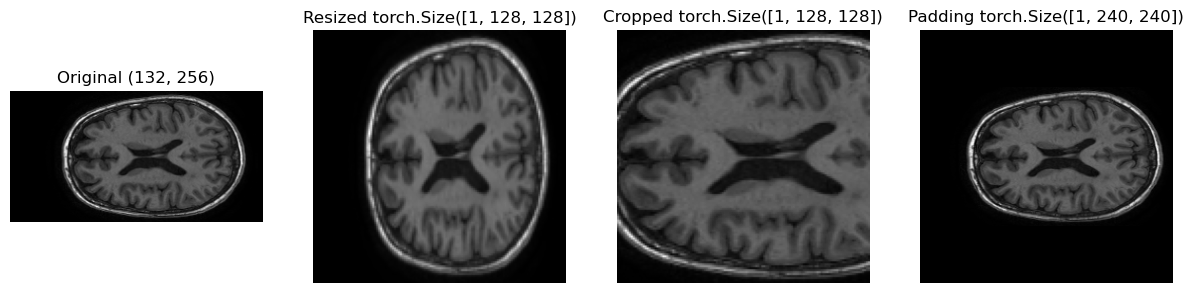

In [48]:
fig,axs = plt.subplots(1, 4, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_res=add_transformation(image_data[:, :, 53],128, True, False)
axs[1].imshow(image_res.squeeze(0), cmap='gray')
axs[1].set_title("Resized %s" %(image_res.shape,))
axs[1].axis('off')

image_crop=add_transformation(image_data[:, :, 53],128, False,False)
axs[2].imshow(image_crop.squeeze(0), cmap='gray')
axs[2].set_title("Cropped %s" %(image_crop.shape,))
axs[2].axis('off')

image_pad=add_transformation(image_data[:, :, 53],240, False,False)
axs[3].imshow(image_pad.squeeze(0), cmap='gray')
axs[3].set_title("Padding %s" %(image_pad.shape,))
axs[3].axis('off')


(-0.5, 239.5, 239.5, -0.5)

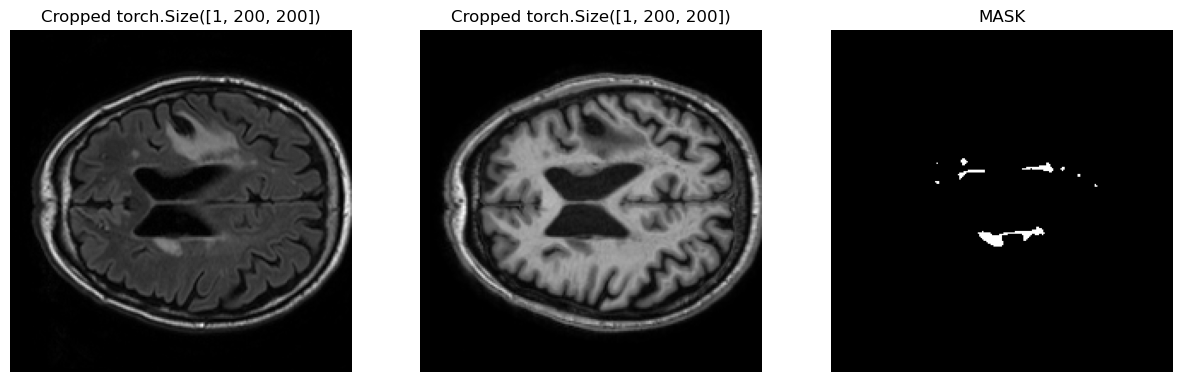

In [34]:
fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_UTRECHT, "19","pre","FLAIR.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_crop=add_transformation(image_data[:, :, 31],200, False,False)
axs[0].imshow(image_crop.squeeze(0), cmap='gray')
axs[0].set_title("Cropped %s" %(image_crop.shape,))
axs[0].axis('off')

flair= os.path.join(TRAINING_PATH_UTRECHT, "19","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_crop=add_transformation(image_data[:, :, 31],200, False,False)
axs[1].imshow(image_crop.squeeze(0), cmap='gray')
axs[1].set_title("Cropped %s" %(image_crop.shape,))
axs[1].axis('off')

mask= os.path.join(TRAINING_PATH_UTRECHT, "19", "wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==1]=255
merged_image[merged_image==2]=0
merged_image[merged_image==3]=255
image_data= merged_image


axs[2].imshow(image_data[:, :,31], cmap='gray')
axs[2].set_title("MASK")
axs[2].axis('off')

# Skull stripping

# Concatenar imágenes

(-0.5, 255.5, 131.5, -0.5)

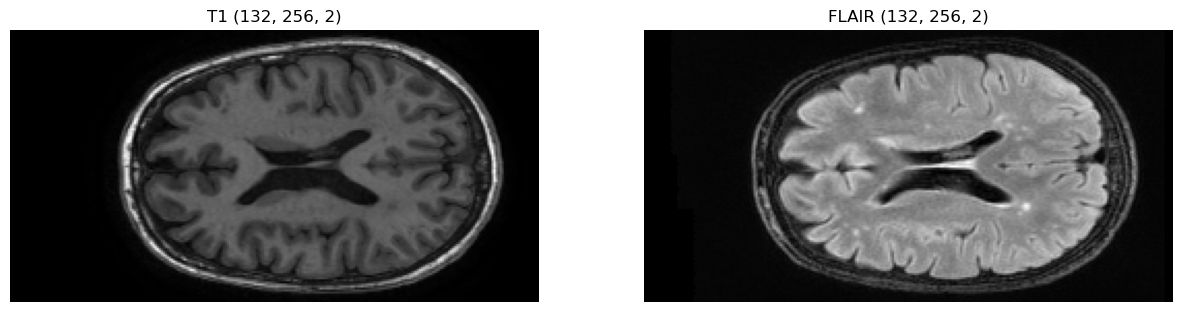

In [50]:
fig,axs = plt.subplots(1, 2, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
t1=os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")

fl = nibabel.load(flair)
fl_data = fl.get_fdata()[:,:,53] 
t=nibabel.load(t1)
t_data=t.get_fdata()[:,:,53] 
image_orig=numpy.concatenate((t_data[...,np.newaxis],fl_data[...,np.newaxis]), axis=2)
axs[0].imshow(image_orig[...,0], cmap='gray')
axs[0].set_title("T1 %s" %(image_orig.shape,))
axs[0].axis('off')

axs[1].imshow(image_orig[...,1], cmap='gray')
axs[1].set_title("FLAIR %s" %(image_orig.shape,))
axs[1].axis('off')

## Brain Filling &  Normalización

(-0.5, 255.5, 131.5, -0.5)

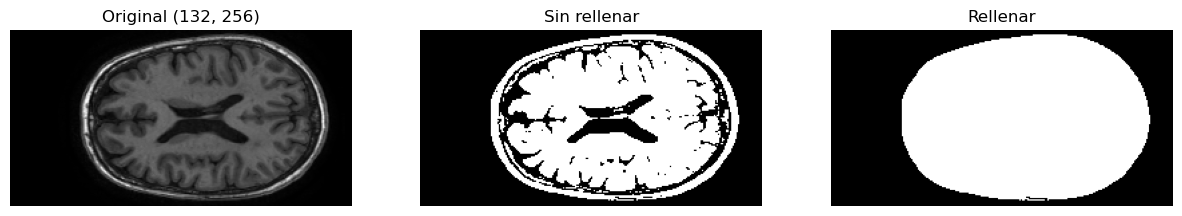

In [51]:
fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')


mask= brainMask(image_orig)
axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Sin rellenar")
axs[1].axis('off')


mask= brainfilling(mask)
axs[2].imshow(mask, cmap='gray')
axs[2].set_title("Rellenar")
axs[2].axis('off')


(-0.5, 255.5, 131.5, -0.5)

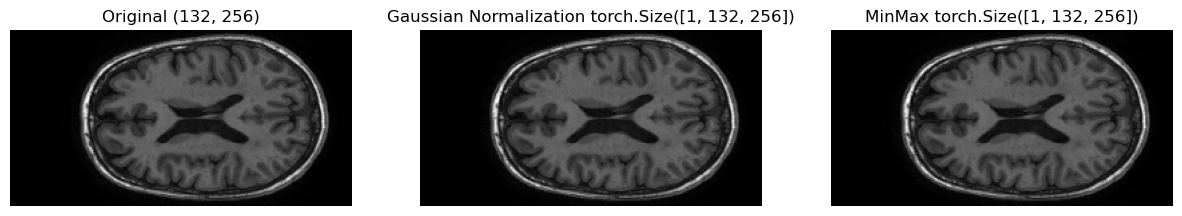

In [52]:

fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')
mask_tensor= transforms.ToTensor()(mask)
image_res=gaussian_normalizationFILL(transforms.ToTensor()(image_data[:, :, 53]), mask_tensor)
axs[1].imshow(image_res.squeeze(0), cmap='gray')
axs[1].set_title("Gaussian Normalization %s" %(image_res.shape,))
axs[1].axis('off')

image_crop=minmax_normalizationFILL(transforms.ToTensor()(image_data[:, :, 53]), mask_tensor)
axs[2].imshow(image_crop.squeeze(0), cmap='gray')
axs[2].set_title("MinMax %s" %(image_crop.shape,))
axs[2].axis('off')

# MÉTODOS ENTRENAMIENTO

In [6]:
from unet import UNet 
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = UNet(in_channels=1,out_channels=1, init_features=32)
model=model.to(device)

In [7]:
def traintestpipeline(epochs: int, optim: Adam, criterion: DiceLoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        

            input_img= input_img.to(device).float()
            target = target.to(device).float()
            
            
            output = model(input_img)
            loss = criterion(output, target)
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()    
                                                        
        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in val_dl: 
                input_img = input_img.to(device).float()
                target = target.to(device)
                
                output = model(input_img)                                   
                loss = criterion(output, target)   
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(val_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

- dice coefficient
- hausdorf distance
- precision
- accuracy
- Intersection over Union(IOU)

- Average volume difference (in percentage)
- Sensitivity for individual lesions (recall)
-  F1-score for individual lesions

https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f 

In [8]:
def precision_score(pred_mask,groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = torch.sum(pred_mask)
    if total_pixel_pred == 0:
        return torch.tensor(0.0, device=pred_mask.device)
    precision = torch.mean(intersect/total_pixel_pred)
    return precision

def recall_score(pred_mask, groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = torch.sum(groundtruth_mask)
    if(torch.all(total_pixel_truth==0)):
        recall= torch.tensor(0.0)
    else:    
        recall = torch.mean(intersect/total_pixel_truth)
    return recall

def accuracy(pred_mask,groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    xor = torch.sum(groundtruth_mask==pred_mask)
    if (union + xor - intersect) == 0:
        return torch.tensor(0.0, device=pred_mask.device)
    acc = torch.mean(xor/(union + xor - intersect))
    return acc

def iou_score(pred_mask, groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    if union == 0:
        return torch.tensor(0.0, device=pred_mask.device)
    iou = torch.mean(intersect/union)
    return iou
def dice_coeff(y_true, y_pred):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    
    y_true_f = y_true_f.float()
    y_pred_f = y_pred_f.float()
    
    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f)
    if union == 0:
        return torch.tensor(0.0, device=y_pred_f.device)
    dice_coeff = (2. * intersection) / (union)
    
    return dice_coeff

https://github.com/Project-MONAI/MONAI/discussions/2179 problema con HausdorffDistance

In [9]:
import torch
from monai.metrics import DiceMetric, HausdorffDistanceMetric, get_mask_edges, get_surface_distance

def calculate_metrics(model, test_dl, device):
    model.eval()
    total_dice = 0
    total_hd = 0
    total_pre = 0
    total_rec = 0
    total_acc = 0
    total_iou=0
    total = len(test_dl)
    

    dice_metric = DiceMetric(include_background=True, reduction="mean")
    hd_metric = HausdorffDistanceMetric(include_background=True, reduction="mean")

    with torch.no_grad():
        for input_img, target in test_dl:
            input_img = input_img.to(device).float()
            target = target.to(device).float()

            output = model(input_img)
            dice = dice_coeff(output, target)
            dice = np.nan_to_num(dice.cpu().numpy())
            total_dice += dice.mean()

            output = (output > 0.5).float()
            target= (target > 0.5).float()
            pre = precision_score(output, target)
            total_pre+=pre

            rec = recall_score(output, target)
            total_rec+=rec

            acc = accuracy(output, target)
            total_acc+=acc

            iou = iou_score(output, target)
            total_iou+=iou
            


    total_dice /= total
    total_hd /= total
    total_pre /=total
    total_rec /=total
    total_acc /=total
    total_iou /= total
    print("Dice coefficient:", total_dice)
    print("IOU:", total_iou)
    #print("Hausdorff Distance:", total_hd)
    print("Precision:", total_pre)
    print("Recall:", total_rec)
    print("Accuracy:", total_acc)


In [10]:
def assignPretrainedModel(device,name:str):
    mmodel =  model.to(device)
    mmodel.load_state_dict(torch.load(name))
    mmodel.eval();
    return mmodel

## Modelo con todo el conjunto de imágenes

In [128]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2934
646


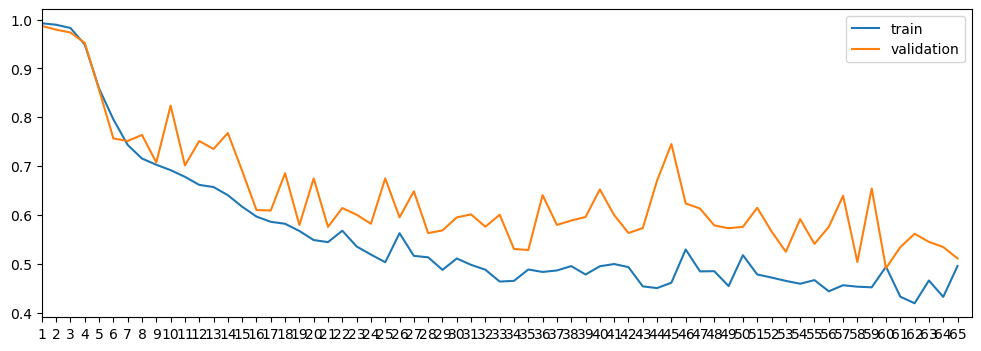

Epoch:65 Training Loss:0.49536617658177784 Validation Loss:0.5109622383924023: 100%|██████████| 65/65 [31:32<00:00, 29.12s/it]


In [59]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/NODeletion128FLAIR.pt")

In [129]:
model=assignPretrainedModel(device,"./Modelos3DUNET/NODeletion128FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2642673235621571
IOU: tensor(0.1960, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.3107, device='cuda:0')
Recall: tensor(0.2782, device='cuda:0')
Accuracy: tensor(0.3107, device='cuda:0')


In [130]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2934
646


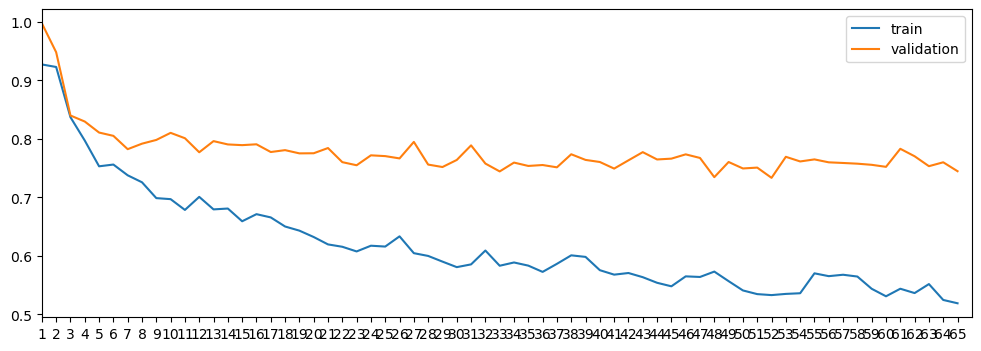

Epoch:65 Training Loss:0.5189562730248405 Validation Loss:0.7448052231558925: 100%|██████████| 65/65 [31:57<00:00, 29.51s/it]


In [62]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/NODeletion128T1.pt")

In [131]:
model=assignPretrainedModel(device,"./Modelos3DUNET/NODeletion128T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.130446057486604
IOU: tensor(0.0888, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.1570, device='cuda:0')
Recall: tensor(0.1516, device='cuda:0')
Accuracy: tensor(0.5441, device='cuda:0')


# Modelo sin el 20% de los slices:

In [132]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


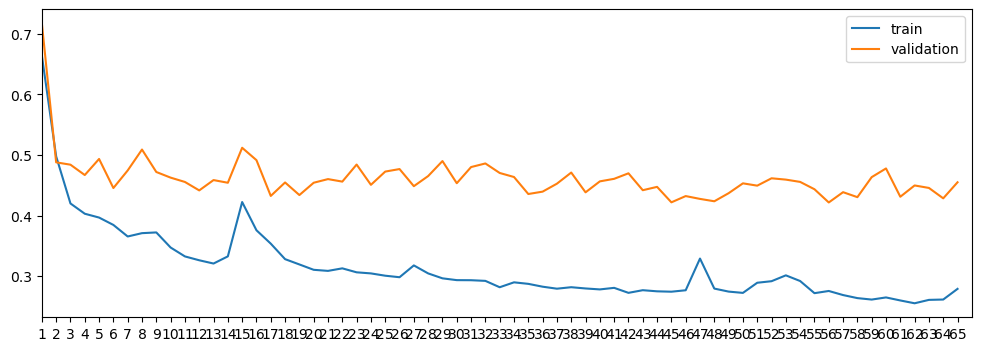

Epoch:65 Training Loss:0.27919727080639956 Validation Loss:0.45506661065186926: 100%|██████████| 65/65 [25:23<00:00, 23.44s/it]


In [65]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Deletion128FLAIR.pt")

In [133]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Deletion128FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.3411558232451578
IOU: tensor(0.2560, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.4202, device='cuda:0')
Recall: tensor(0.3669, device='cuda:0')
Accuracy: tensor(0.7963, device='cuda:0')


In [134]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


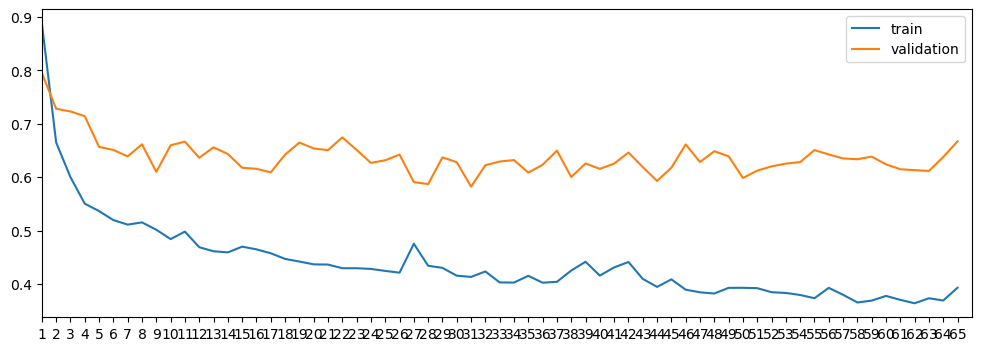

Epoch:65 Training Loss:0.3928702936600089 Validation Loss:0.6669611046281557: 100%|██████████| 65/65 [25:22<00:00, 23.43s/it] 


In [68]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Deletion128T1.pt")

In [135]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Deletion128T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.23150741081552362
IOU: tensor(0.1570, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2793, device='cuda:0')
Recall: tensor(0.2476, device='cuda:0')
Accuracy: tensor(0.6822, device='cuda:0')


# Modelos con Resize 

Se asume que sin los slices el modelo es mejor(Pendiente de los resultados)

## 128x128 

In [136]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


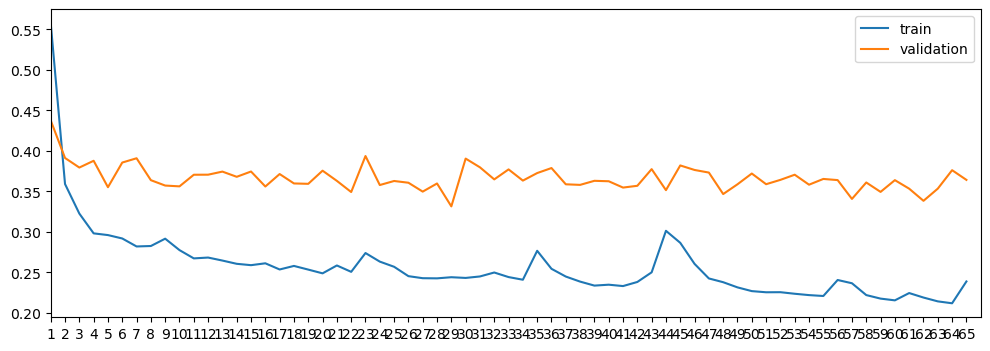

Epoch:65 Training Loss:0.23868615256699535 Validation Loss:0.3641761832421719: 100%|██████████| 65/65 [25:22<00:00, 23.43s/it]


In [71]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize128FLAIR.pt")

In [137]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize128FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.3870374866187094
IOU: tensor(0.2956, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.4202, device='cuda:0')
Recall: tensor(0.4276, device='cuda:0')
Accuracy: tensor(0.8142, device='cuda:0')


In [138]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


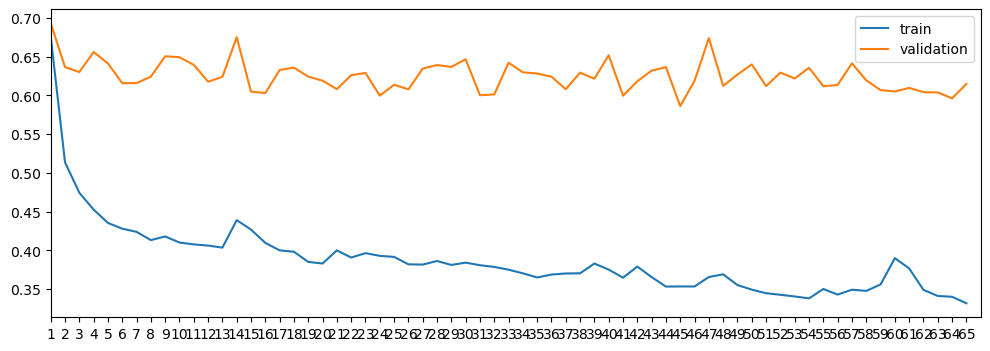

Epoch:65 Training Loss:0.3315331227937885 Validation Loss:0.6149533975291193: 100%|██████████| 65/65 [25:27<00:00, 23.50s/it] 


In [74]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize128T1.pt")

In [139]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize128T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2419345638869345
IOU: tensor(0.1661, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2729, device='cuda:0')
Recall: tensor(0.2648, device='cuda:0')
Accuracy: tensor(0.8492, device='cuda:0')


## 256 x 256

In [140]:
transform, transform_label=transform_setter(256,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


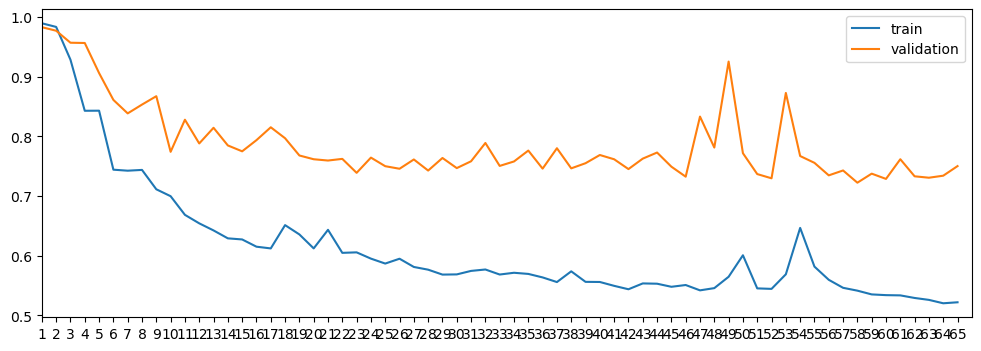

Epoch:65 Training Loss:0.521829226353854 Validation Loss:0.7502881966082174: 100%|██████████| 65/65 [1:28:10<00:00, 81.39s/it]


In [13]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize256FLAIR.pt")

In [141]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.16810657032668636
IOU: tensor(0.1228, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2360, device='cuda:0')
Recall: tensor(0.3239, device='cuda:0')
Accuracy: tensor(0.0823, device='cuda:0')


In [142]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


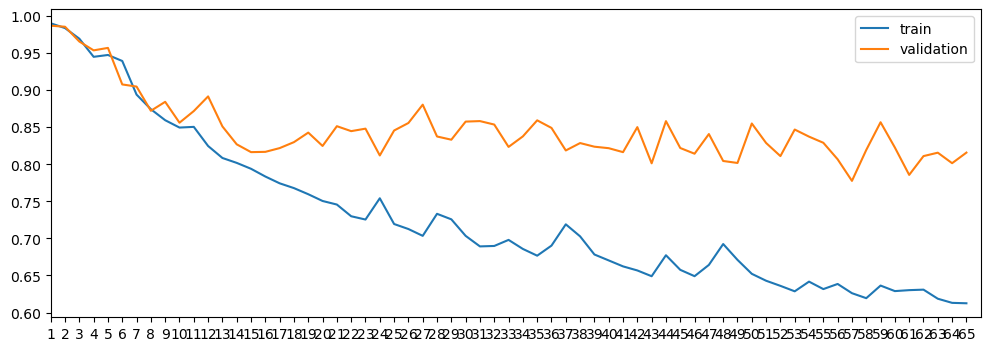

Epoch:65 Training Loss:0.6124501564837799 Validation Loss:0.8157876502413118: 100%|██████████| 65/65 [1:28:12<00:00, 81.42s/it]


In [15]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize256T1.pt")

In [143]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.124042861538899
IOU: tensor(0.0810, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.1765, device='cuda:0')
Recall: tensor(0.1163, device='cuda:0')
Accuracy: tensor(0.2848, device='cuda:0')


## 384 x 384

In [144]:
transform, transform_label=transform_setter(384,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,7,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


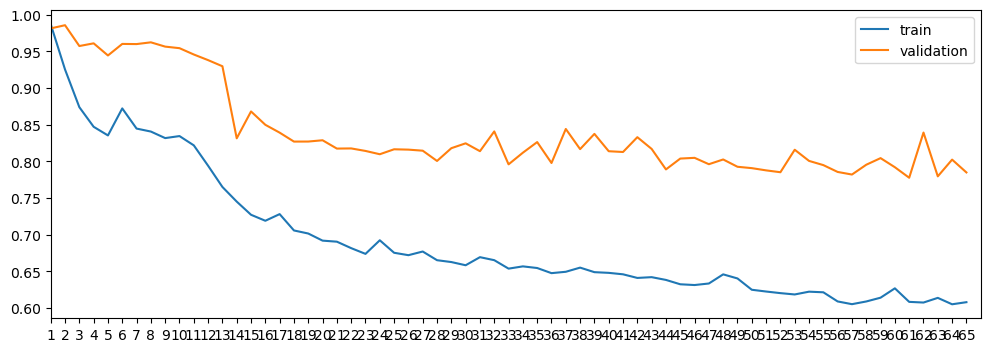

Epoch:65 Training Loss:0.6078835335130188 Validation Loss:0.7847929960223489: 100%|██████████| 65/65 [3:18:00<00:00, 182.77s/it]


In [12]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize384FLAIR.pt")

In [145]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize384FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.18028601108370318
IOU: tensor(0.1312, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2579, device='cuda:0')
Recall: tensor(0.2932, device='cuda:0')
Accuracy: tensor(0.0945, device='cuda:0')


In [146]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,7,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


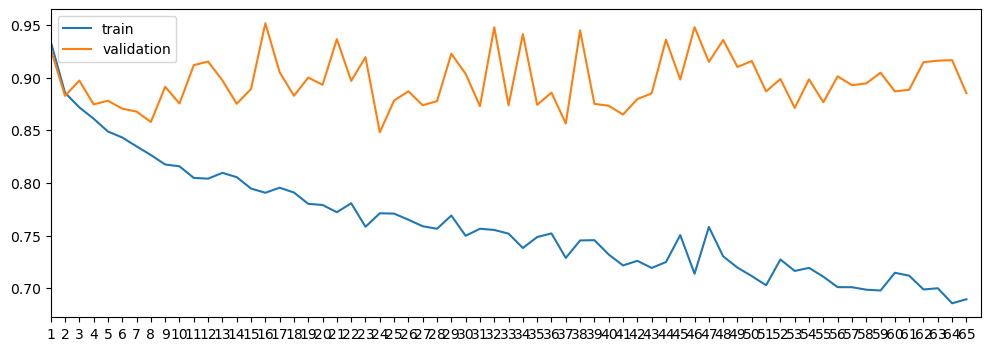

Epoch:65 Training Loss:0.6895356822278993 Validation Loss:0.8851277887104192: 100%|██████████| 65/65 [3:18:30<00:00, 183.24s/it]


In [15]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize384T1.pt")

In [147]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize384T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.10868390345887258
IOU: tensor(0.0695, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.1505, device='cuda:0')
Recall: tensor(0.1032, device='cuda:0')
Accuracy: tensor(0.3938, device='cuda:0')


## 200 x 200

In [148]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=True,is200crop=False)
model=model.to(device)

In [149]:
transform, transform_label=transform_setter(200,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


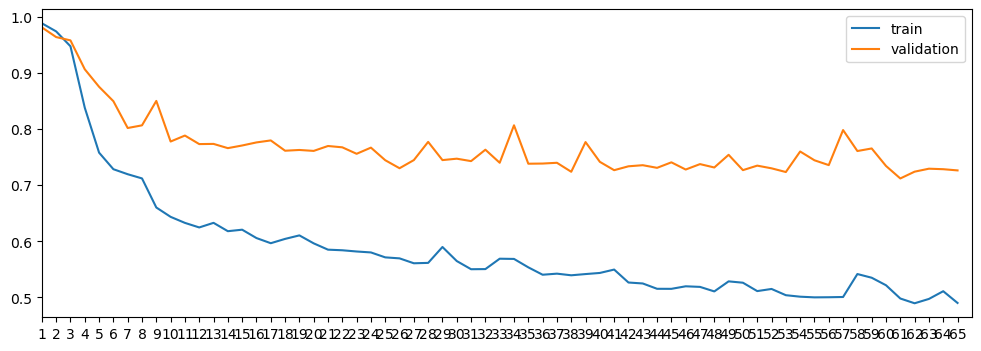

Epoch:65 Training Loss:0.490228610269485 Validation Loss:0.7264737258780394: 100%|██████████| 65/65 [57:38<00:00, 53.20s/it] 


In [56]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200FLAIRpad.pt")

In [150]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200FLAIRpad.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.18704665786514324
IOU: tensor(0.1350, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2351, device='cuda:0')
Recall: tensor(0.2703, device='cuda:0')
Accuracy: tensor(0.0890, device='cuda:0')


In [151]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


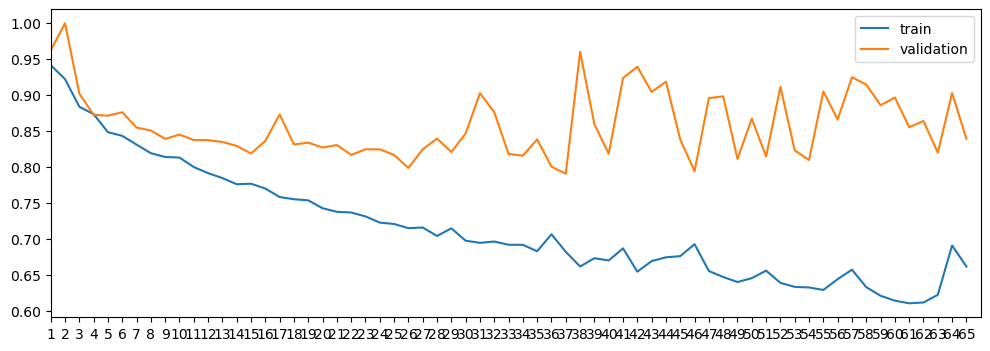

Epoch:65 Training Loss:0.6619031471590842 Validation Loss:0.8393915439725385: 100%|██████████| 65/65 [59:24<00:00, 54.84s/it]


In [37]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200T1pad.pt")

In [152]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200T1pad.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.11340926978634594
IOU: tensor(0.0732, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.1442, device='cuda:0')
Recall: tensor(0.1302, device='cuda:0')
Accuracy: tensor(0.4629, device='cuda:0')


In [153]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=False,is200crop=True)
model=model.to(device)

In [154]:
transform, transform_label=transform_setter(200,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


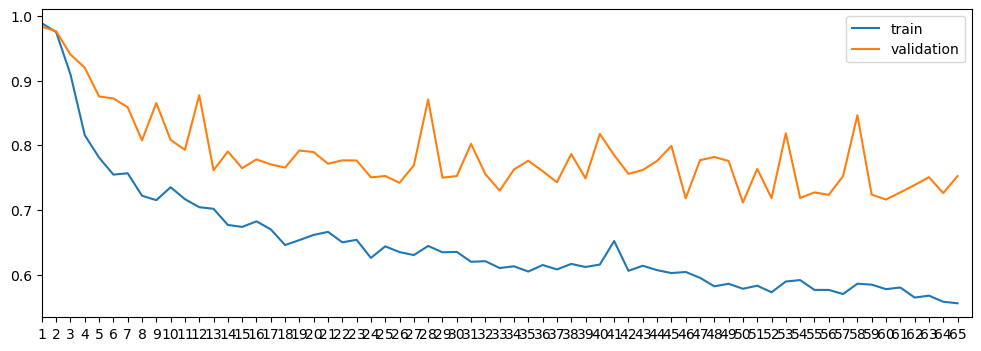

Epoch:65 Training Loss:0.5557551899263936 Validation Loss:0.7524185538142478: 100%|██████████| 65/65 [1:04:29<00:00, 59.53s/it]


In [41]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200FLAIRcrop.pt")

In [155]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200FLAIRcrop.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.18809440595333005
IOU: tensor(0.1294, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2705, device='cuda:0')
Recall: tensor(0.2376, device='cuda:0')
Accuracy: tensor(0.0618, device='cuda:0')


In [156]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


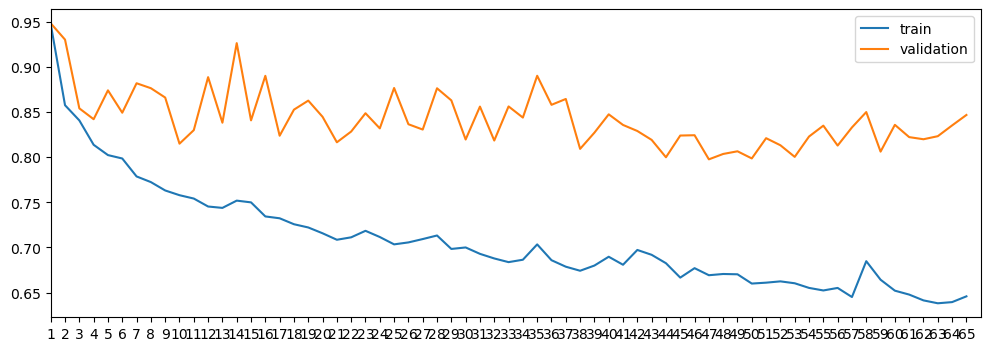

Epoch:65 Training Loss:0.6457715630531311 Validation Loss:0.846815481841137: 100%|██████████| 65/65 [1:04:24<00:00, 59.45s/it] 


In [44]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200T1crop.pt")

In [157]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200T1crop.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.12575574566407768
IOU: tensor(0.0821, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.1525, device='cuda:0')
Recall: tensor(0.1422, device='cuda:0')
Accuracy: tensor(0.3340, device='cuda:0')


# Modelos con Crop/Pad

## 200 x 200

CROP MEJOR

In [171]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=False,is200crop=True)
model=model.to(device)

In [172]:
transform, transform_label=transform_setter(200,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


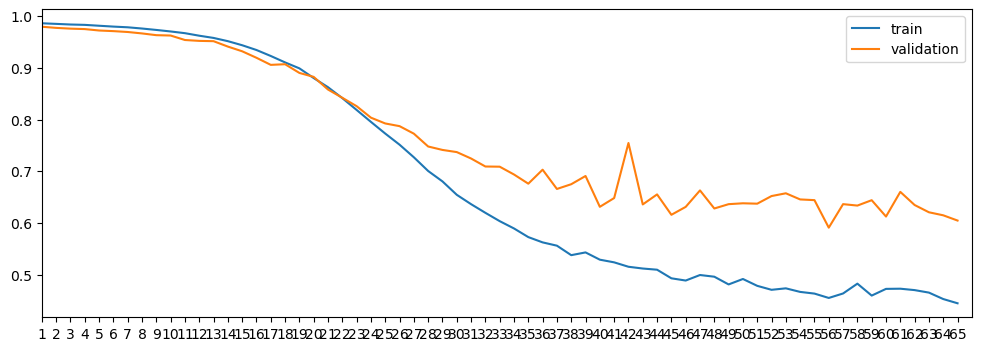

Epoch:65 Training Loss:0.44429534865963843 Validation Loss:0.6044571377218159: 100%|██████████| 65/65 [1:04:46<00:00, 59.80s/it]


In [175]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200FLAIR.pt")

In [176]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop200FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.28973411699269874
IOU: tensor(0.2062, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.3576, device='cuda:0')
Recall: tensor(0.3142, device='cuda:0')
Accuracy: tensor(0.1067, device='cuda:0')


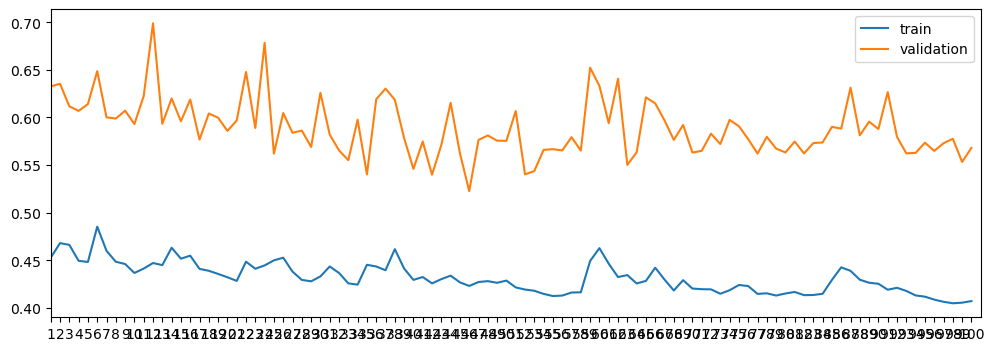

Epoch:100 Training Loss:0.4071638153445336 Validation Loss:0.5681080813068957: 100%|██████████| 100/100 [1:40:35<00:00, 60.36s/it]


In [177]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200FLAIR100.pt")

In [178]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop200FLAIR100.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.32601209665092934
IOU: tensor(0.2383, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.4008, device='cuda:0')
Recall: tensor(0.3415, device='cuda:0')
Accuracy: tensor(0.1304, device='cuda:0')


In [179]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


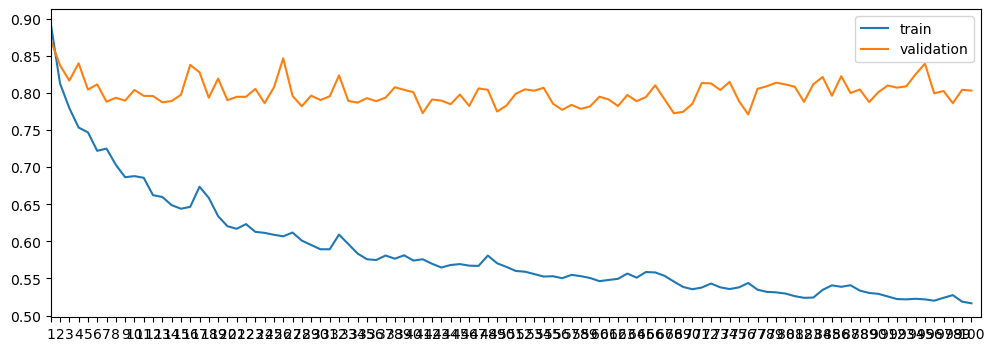

Epoch:100 Training Loss:0.5165437763737094 Validation Loss:0.8032787817651785: 100%|██████████| 100/100 [1:40:31<00:00, 60.31s/it]


In [180]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200T1.pt")

In [181]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop200T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.13880247289963896
IOU: tensor(0.0925, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.1854, device='cuda:0')
Recall: tensor(0.1305, device='cuda:0')
Accuracy: tensor(0.0371, device='cuda:0')


## 240 x240

In [158]:
model = UNet(in_channels=1,out_channels=1, init_features=32)
model=model.to(device)

In [159]:
transform, transform_label=transform_setter(240,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


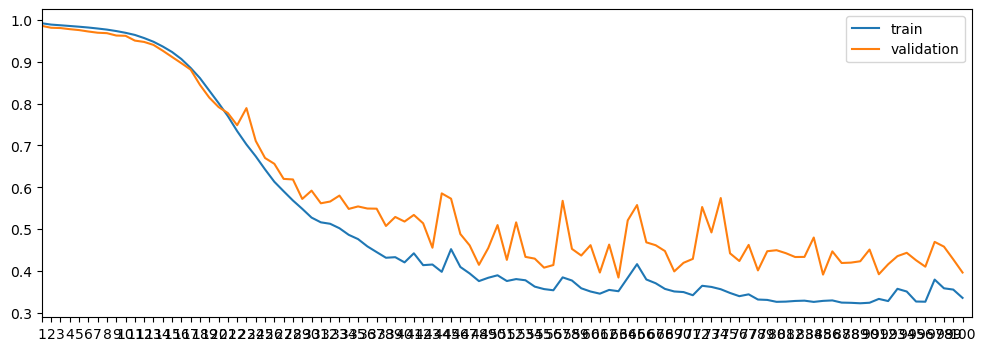

Epoch:100 Training Loss:0.33608962951167937 Validation Loss:0.3966346077651867: 100%|██████████| 100/100 [2:09:10<00:00, 77.50s/it]


In [17]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop240FLAIR.pt")

In [160]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop240FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.42446091250470264
IOU: tensor(0.3371, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.5163, device='cuda:0')
Recall: tensor(0.4119, device='cuda:0')
Accuracy: tensor(0.2312, device='cuda:0')


In [161]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


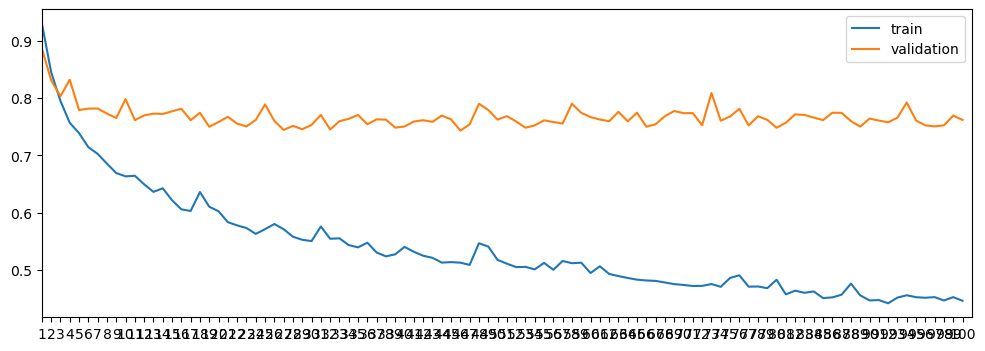

Epoch:100 Training Loss:0.4465693700698114 Validation Loss:0.7617159340779408: 100%|██████████| 100/100 [2:09:09<00:00, 77.50s/it]


In [20]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop240T1.pt")

In [162]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.16394134801844323
IOU: tensor(0.1136, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2277, device='cuda:0')
Recall: tensor(0.1491, device='cuda:0')
Accuracy: tensor(0.0431, device='cuda:0')


## 256 x 256

In [163]:
transform, transform_label=transform_setter(256,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


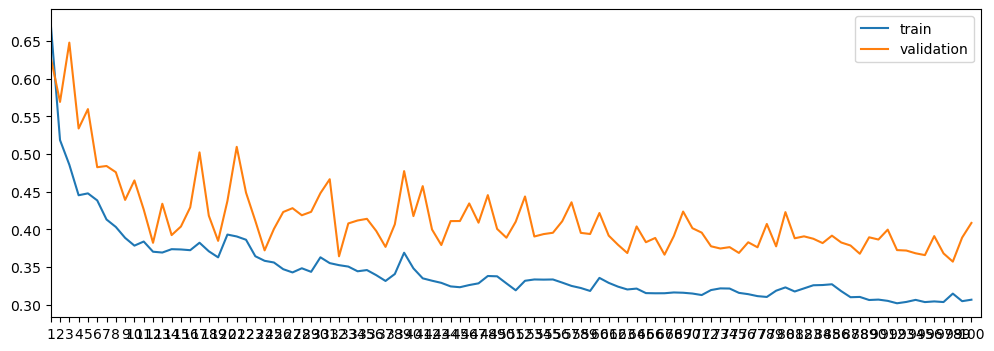

Epoch:100 Training Loss:0.306595306627212 Validation Loss:0.4084804055300735: 100%|██████████| 100/100 [2:25:22<00:00, 87.23s/it]


In [23]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop256FLAIR.pt")

In [164]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4338665886218754
IOU: tensor(0.3480, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.5175, device='cuda:0')
Recall: tensor(0.4505, device='cuda:0')
Accuracy: tensor(0.4506, device='cuda:0')


In [165]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


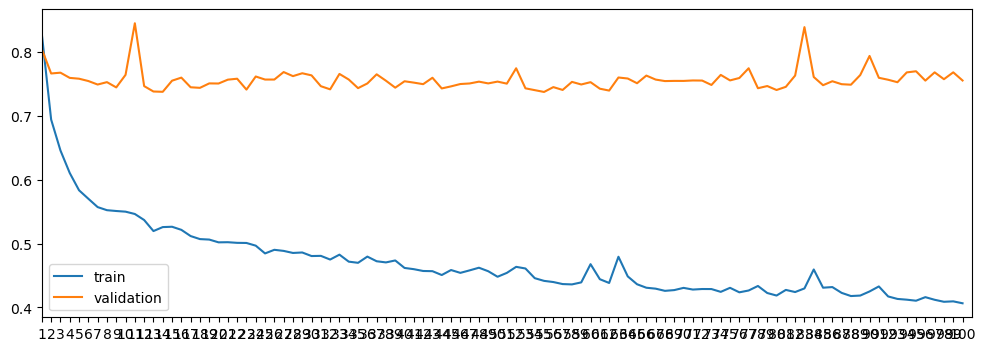

Epoch:100 Training Loss:0.40637190341949464 Validation Loss:0.7556499802766355: 100%|██████████| 100/100 [2:21:27<00:00, 84.88s/it]


In [26]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop256T1.pt")

In [166]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.16512034801414596
IOU: tensor(0.1139, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2397, device='cuda:0')
Recall: tensor(0.1470, device='cuda:0')
Accuracy: tensor(0.4510, device='cuda:0')


## 384 x 384

In [167]:
transform, transform_label=transform_setter(384,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,7,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


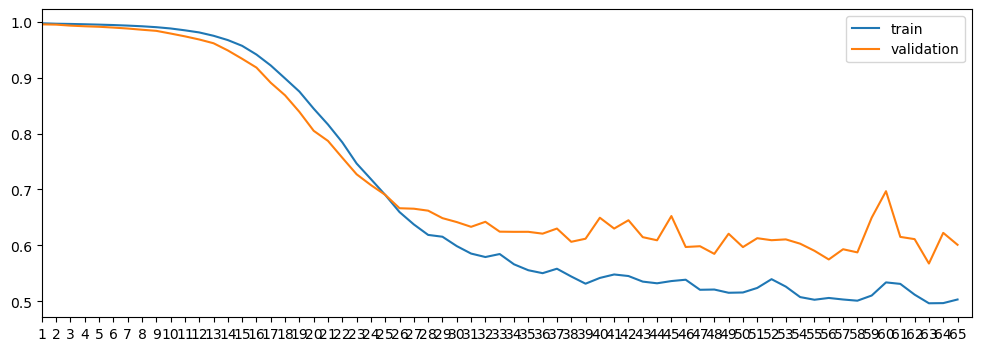

Epoch:65 Training Loss:0.5035260894147291 Validation Loss:0.6012212911656315: 100%|██████████| 65/65 [3:20:23<00:00, 184.98s/it] 


In [12]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop384FLAIR.pt")

In [168]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop384FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.41639925510485737
IOU: tensor(0.3211, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.5140, device='cuda:0')
Recall: tensor(0.4470, device='cuda:0')
Accuracy: tensor(0.2592, device='cuda:0')


In [169]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,7,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


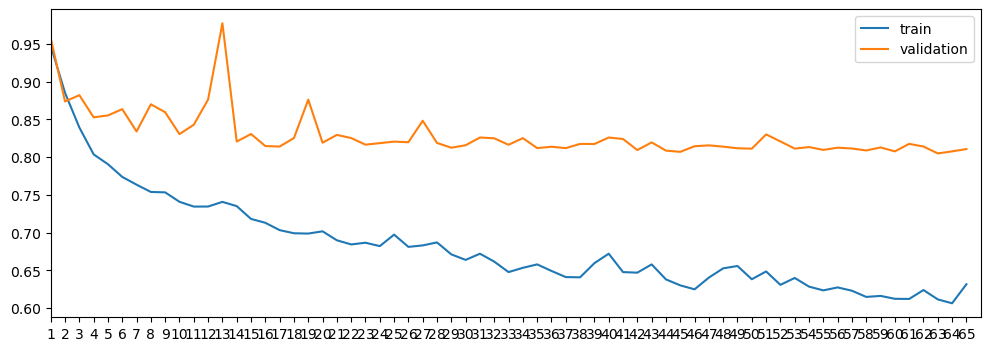

Epoch:65 Training Loss:0.6316726184323475 Validation Loss:0.8107886747356172: 100%|██████████| 65/65 [3:23:10<00:00, 187.55s/it]


In [15]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop384T1.pt")

In [170]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop384T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.1726276970270722
IOU: tensor(0.1174, device='cuda:0')
Hausdorff Distance: 0.0
Precision: tensor(0.2365, device='cuda:0')
Recall: tensor(0.1607, device='cuda:0')
Accuracy: tensor(0.5232, device='cuda:0')


# Modelos con Normalizacion

Se asume un tamaño con Reize de 256x256(pendiente resultados)
Se asume un tamaño con Crop and Pad de 200x200(pendiente resultados)

## Gaussian Normalization Resize 256x256

- 1: Gaussian normalization
- 3: Gaussian Normalization cerebro
- 5: gaussian normalization del cerebro completo

In [32]:
transform, transform_label=transform_normalization(256,True,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


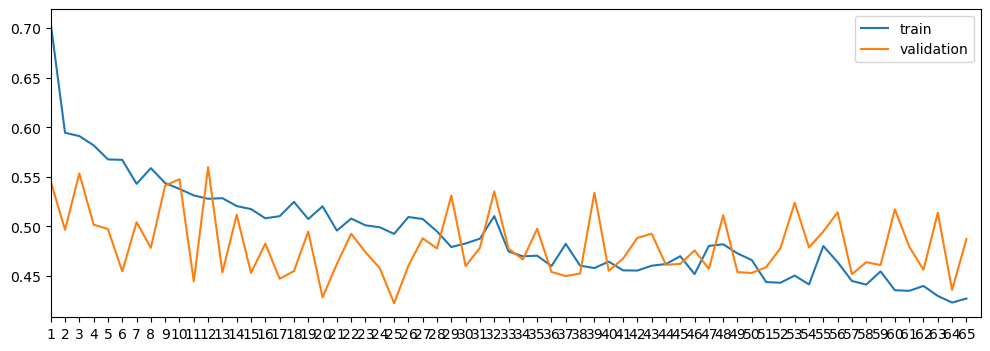

Epoch:65 Training Loss:0.4272668588546015 Validation Loss:0.4873324878069564: 100%|██████████| 65/65 [1:30:44<00:00, 83.76s/it]


In [66]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR.pt")

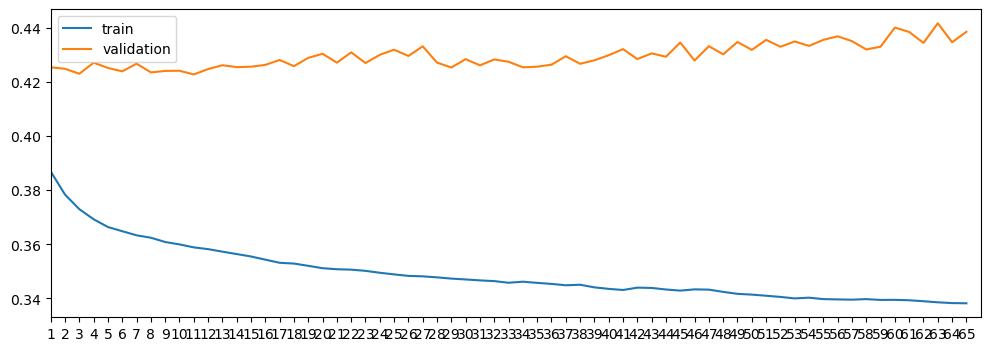

Epoch:65 Training Loss:0.3382336228124557 Validation Loss:0.4384429684066739: 100%|██████████| 65/65 [1:32:00<00:00, 84.94s/it]  


In [33]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIRlr4.pt")

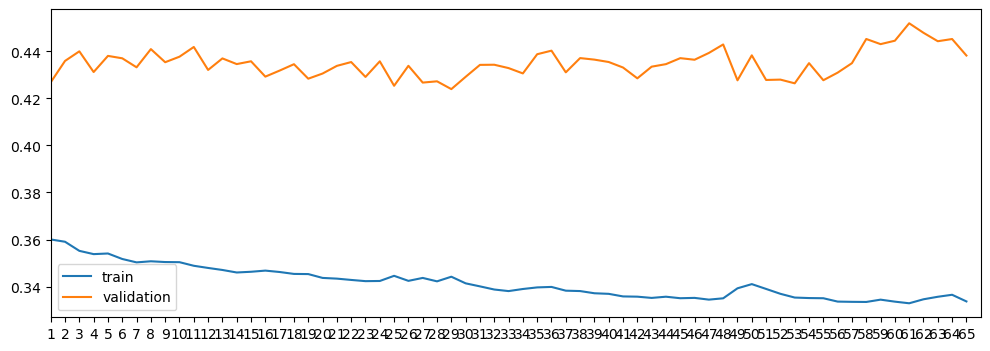

Epoch:65 Training Loss:0.3336930840246139 Validation Loss:0.4382088737084471: 100%|██████████| 65/65 [1:32:08<00:00, 85.06s/it]


In [35]:
epochs = 65
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR0002.pt")

In [67]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.5413, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [34]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256FLAIRlr4.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2421939703721651
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4226, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [36]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR0002.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.2543888839353856
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4431, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [12]:
transform, transform_label=transform_normalization(256,True,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


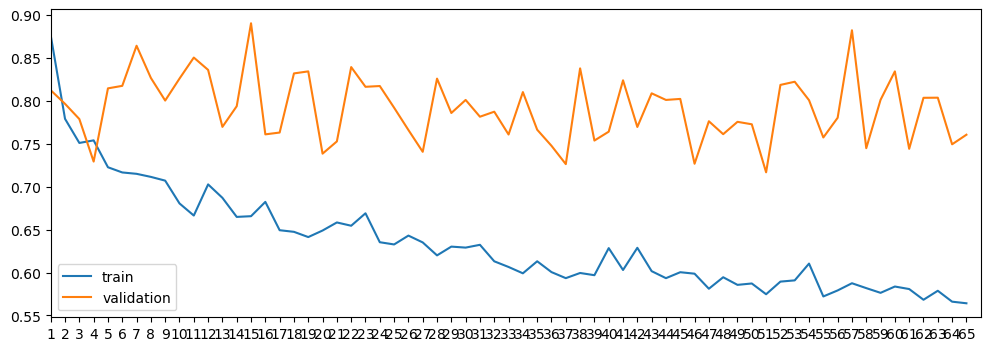

Epoch:65 Training Loss:0.5642118923125728 Validation Loss:0.7602484778189346: 100%|██████████| 65/65 [1:30:49<00:00, 83.84s/it]


In [69]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256T1.pt")

In [70]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


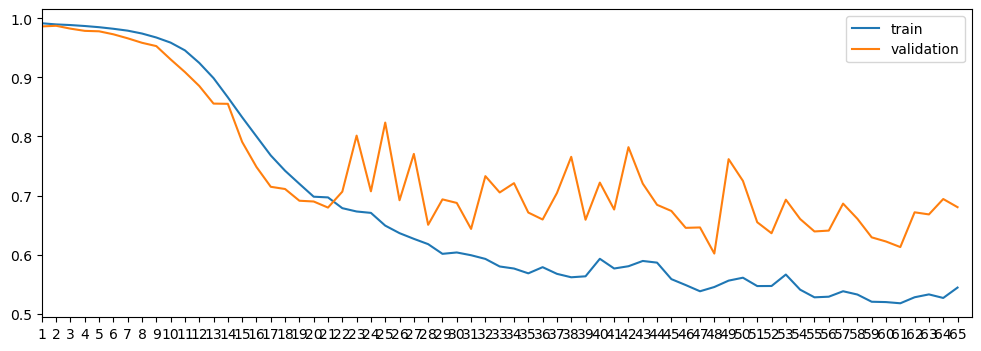

Epoch:65 Training Loss:0.5441224467369818 Validation Loss:0.6802565043309204: 100%|██████████| 65/65 [1:34:31<00:00, 87.25s/it]


In [13]:
epochs = 65
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256T10002.pt")

In [14]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256T10002.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.1432589104029926
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [28]:
transform, transform_label=transform_normalization(256,True,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


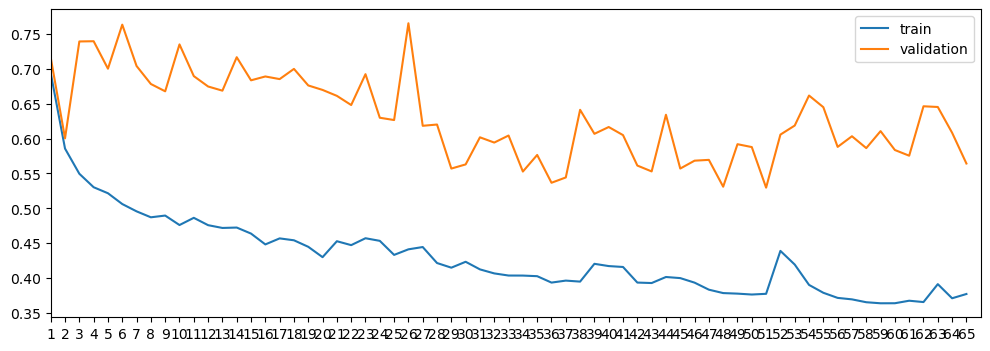

Epoch:65 Training Loss:0.37719703220552014 Validation Loss:0.5641914617834536: 100%|██████████| 65/65 [1:39:33<00:00, 91.90s/it]


In [16]:
epochs = 65
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR.pt")

In [17]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:127: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.15502504040012258
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3832, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


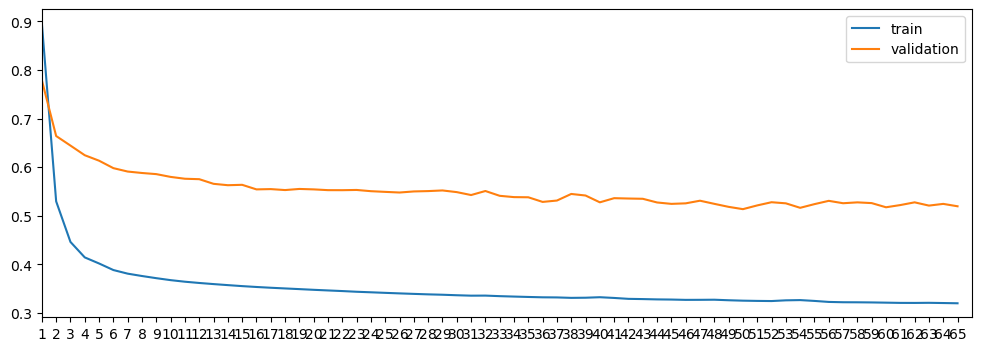

Epoch:65 Training Loss:0.3198143866754347 Validation Loss:0.5193960256768566: 100%|██████████| 65/65 [1:37:11<00:00, 89.72s/it]


In [29]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR02.pt")

In [30]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR02.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2096182477660477
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3899, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [31]:
transform, transform_label=transform_normalization(256,True,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


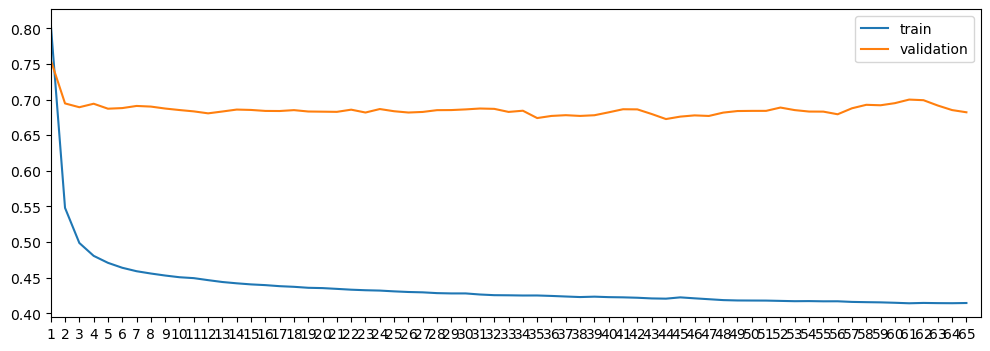

Epoch:65 Training Loss:0.4144139209101277 Validation Loss:0.6821408153823545: 100%|██████████| 65/65 [1:37:07<00:00, 89.65s/it]


In [32]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256T1.pt")

In [34]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNMask256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.10643091979773568
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [35]:
transform, transform_label=transform_normalization(256,True,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


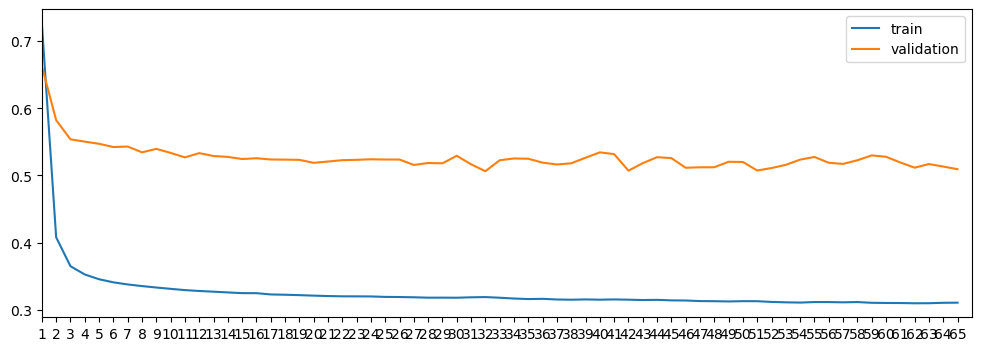

Epoch:65 Training Loss:0.3103890288260675 Validation Loss:0.509324172941598: 100%|██████████| 65/65 [1:43:13<00:00, 95.29s/it] 


In [36]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNFill256FLAIR.pt")

In [37]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNFill256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.22209602917029866
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3966, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [38]:
transform, transform_label=transform_normalization(256,True,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


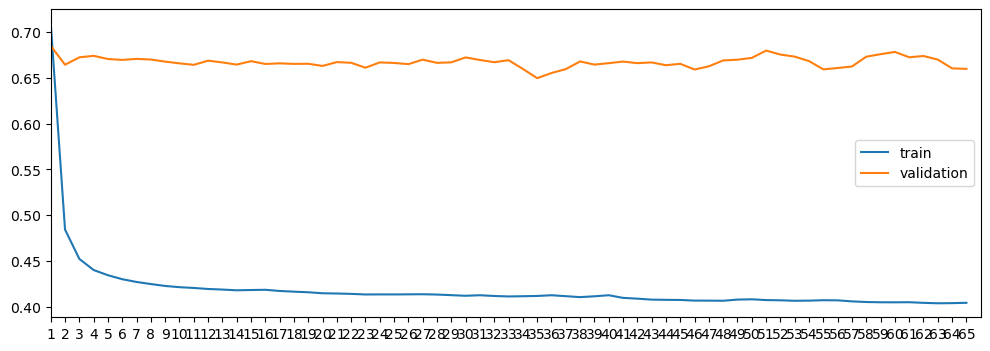

Epoch:65 Training Loss:0.4043501788570035 Validation Loss:0.6597213724539239: 100%|██████████| 65/65 [1:43:33<00:00, 95.59s/it]


In [39]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNFill256T1.pt")

In [40]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNFill256T1.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:127: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.11995184526068012
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


## MINMAX NORMALIZATION RESIZE 256X256

- 2: min max normalization
- 4: min max del cerebro
- 6: minmax del cerebro entero

In [23]:
transform, transform_label=transform_normalization(256,True,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


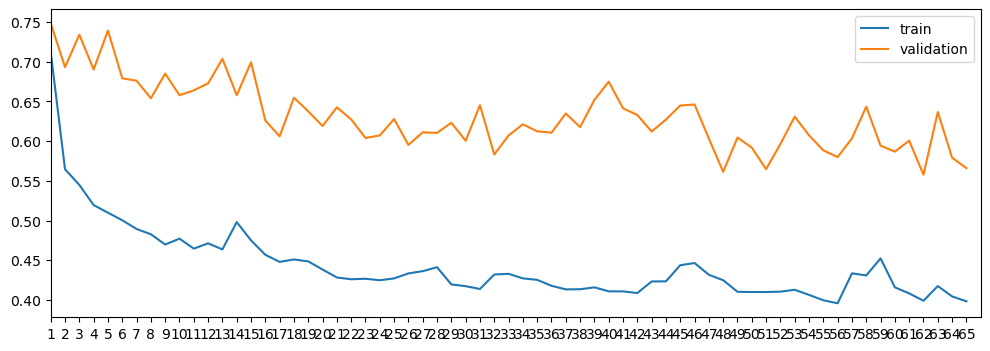

Epoch:65 Training Loss:0.3981597081307442 Validation Loss:0.5659934205133423: 100%|██████████| 65/65 [1:31:41<00:00, 84.64s/it] 


In [24]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MM256FLAIR.pt")

In [25]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MM256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.20378756729187444
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3933, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [26]:
transform, transform_label=transform_normalization(256,True,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


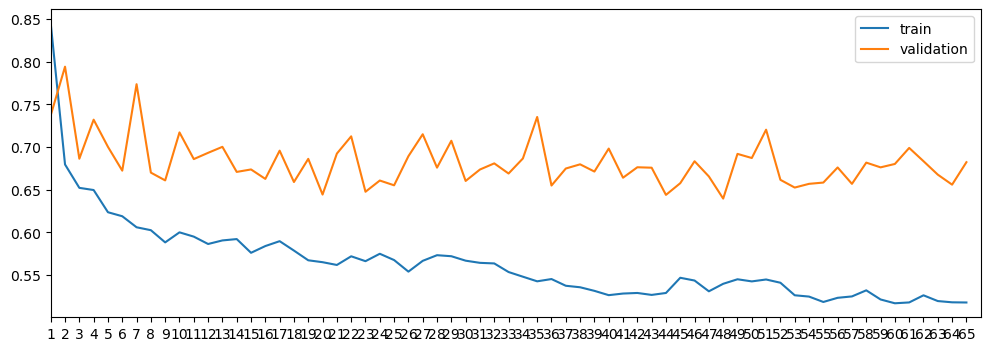

Epoch:65 Training Loss:0.5180127297678302 Validation Loss:0.6822154394175631: 100%|██████████| 65/65 [1:33:06<00:00, 85.94s/it]


In [27]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MM256T1.pt")

In [28]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MM256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.1234064128672655
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [29]:
transform, transform_label=transform_normalization(256,True,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


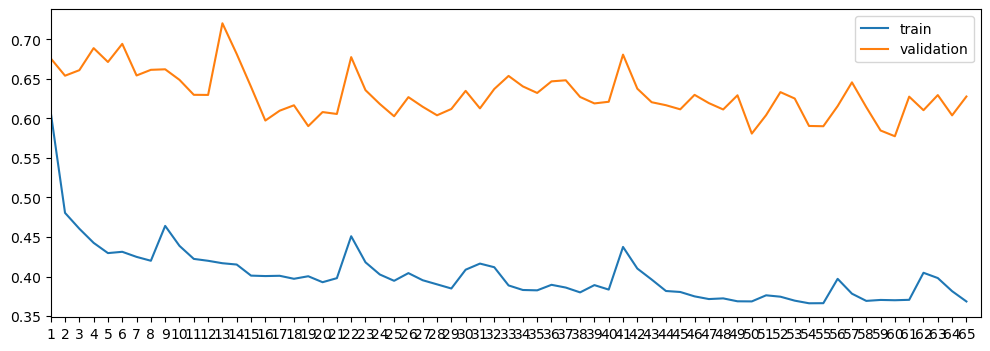

Epoch:65 Training Loss:0.3684891123925486 Validation Loss:0.6276373443359524: 100%|██████████| 65/65 [1:37:48<00:00, 90.28s/it]


In [30]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMmask256FLAIR.pt")

In [31]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MMmask256FLAIR.pt")
calculate_metrics(model,test_dl, device)

RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [ ]:
transform, transform_label=transform_normalization(256,True,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMmask256T1.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MMmask256T1.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(256,True,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMFill256FLAIR.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE//MMFill256FLAIR.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(256,True,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMFill200T1.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MMFill200T1.pt")
calculate_metrics(model,test_dl, device)

## Gaussian Normalization CropandPad 240 x 240 

In [36]:
model = UNet(in_channels=1,out_channels=1, init_features=32)
model= model.to(device)

In [12]:
transform, transform_label=transform_normalization(240,False,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


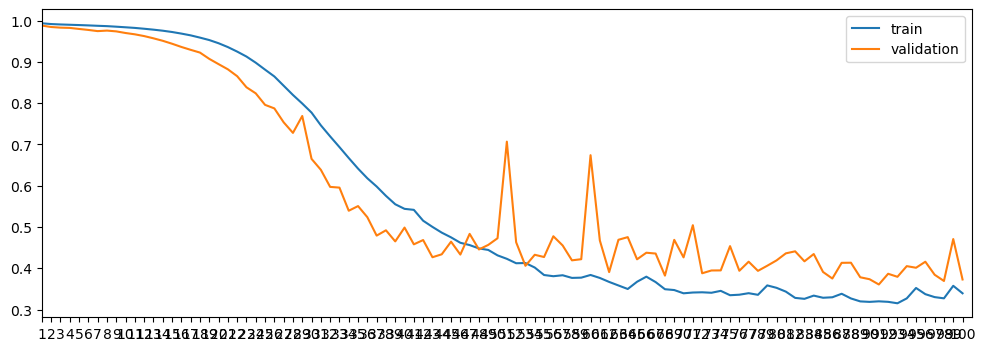

Epoch:100 Training Loss:0.33934510061817785 Validation Loss:0.37282592408464105: 100%|██████████| 100/100 [2:10:41<00:00, 78.42s/it]


In [184]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GN240FLAIR.pt")

In [26]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GN240FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4960328432713004
IOU: tensor(0.4013, device='cuda:0')
Precision: tensor(0.5607, device='cuda:0')
Recall: tensor(0.4823, device='cuda:0')
Accuracy: tensor(0.9993, device='cuda:0')


In [27]:
transform, transform_label=transform_normalization(240,False,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


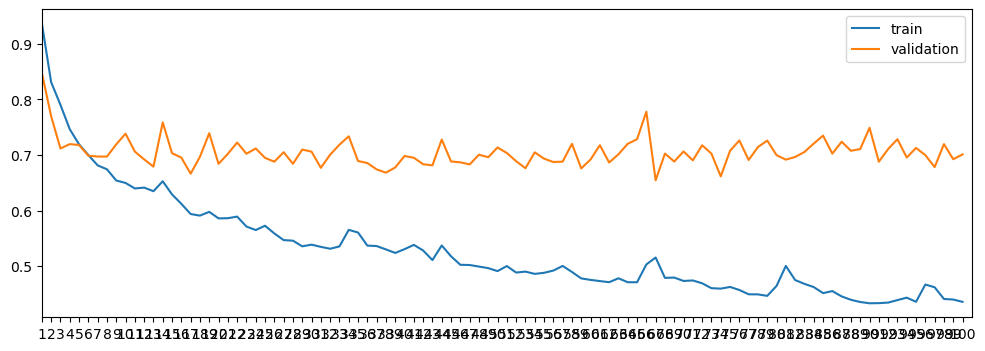

Epoch:100 Training Loss:0.43589559408926193 Validation Loss:0.7008840789056174: 100%|██████████| 100/100 [2:08:29<00:00, 77.09s/it]


In [187]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GN240T1.pt")

In [28]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GN240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2240204293937284
IOU: tensor(0.1530, device='cuda:0')
Precision: tensor(0.3230, device='cuda:0')
Recall: tensor(0.1971, device='cuda:0')
Accuracy: tensor(0.9986, device='cuda:0')


In [29]:
transform, transform_label=transform_normalization(240,False,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


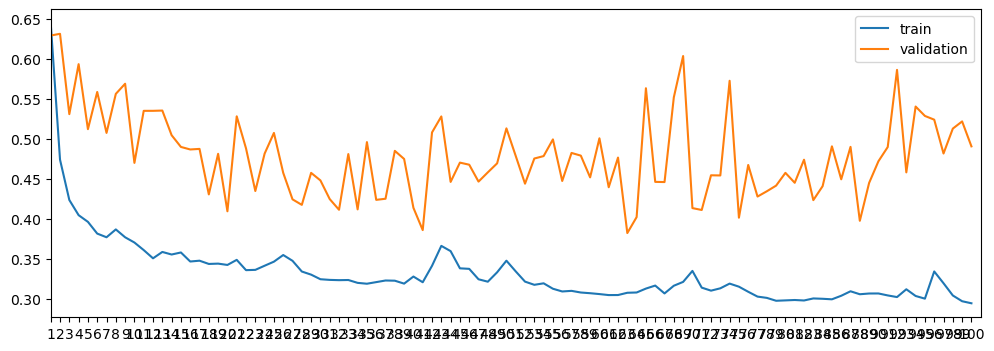

Epoch:100 Training Loss:0.2947978035096199 Validation Loss:0.4908394092883464: 100%|██████████| 100/100 [2:16:39<00:00, 81.99s/it]


In [190]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNMask240FLAIR.pt")

In [30]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNMask240FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:128: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.4648056989895271
IOU: tensor(0.3703, device='cuda:0')
Precision: tensor(0.5793, device='cuda:0')
Recall: tensor(0.4289, device='cuda:0')
Accuracy: tensor(0.9991, device='cuda:0')


0.00005
0.000025

In [31]:
transform, transform_label=transform_normalization(240,False,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


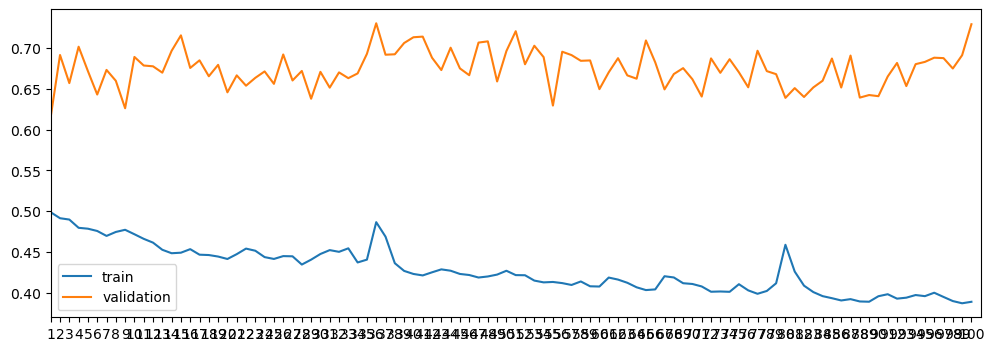

Epoch:100 Training Loss:0.38911405340317756 Validation Loss:0.7291551006145977: 100%|██████████| 100/100 [2:18:08<00:00, 82.88s/it]


In [194]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNMask240T1.pt")

In [32]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNMask240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.24343851160605545
IOU: tensor(0.1698, device='cuda:0')
Precision: tensor(0.3178, device='cuda:0')
Recall: tensor(0.2349, device='cuda:0')
Accuracy: tensor(0.9987, device='cuda:0')


In [33]:
transform, transform_label=transform_normalization(240,False,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


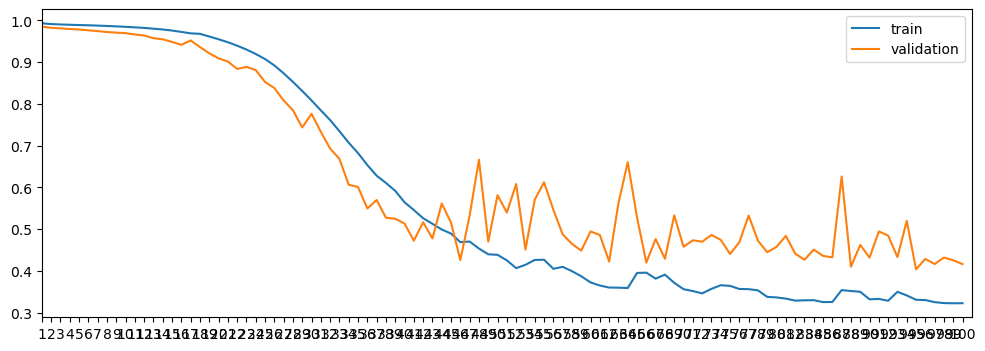

Epoch:100 Training Loss:0.3230087226436984 Validation Loss:0.4165342782779741: 100%|██████████| 100/100 [2:24:35<00:00, 86.75s/it]


In [201]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNFill240FLAIR.pt")

In [34]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNFill240FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.461377140244866
IOU: tensor(0.3645, device='cuda:0')
Precision: tensor(0.5591, device='cuda:0')
Recall: tensor(0.4351, device='cuda:0')
Accuracy: tensor(0.9991, device='cuda:0')


1e-5
0.000025

In [38]:
transform, transform_label=transform_normalization(240,False,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


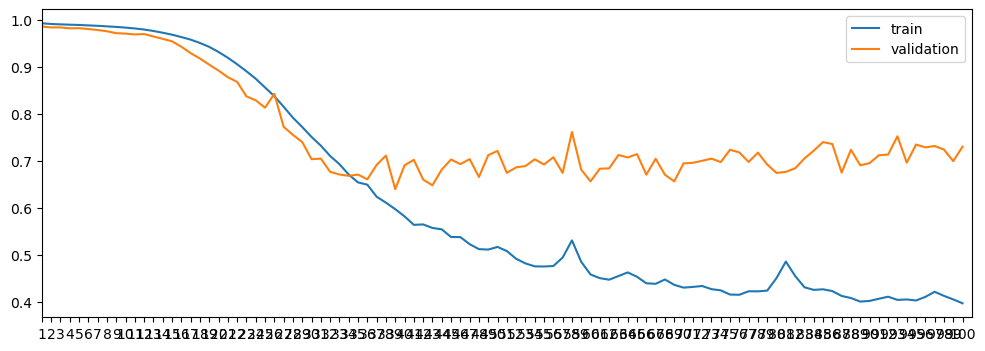

Epoch:100 Training Loss:0.39750465077738606 Validation Loss:0.7306468173983639: 100%|██████████| 100/100 [2:29:20<00:00, 89.61s/it]


In [39]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNFill240T1.pt")

In [40]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNFill240T1.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:128: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.2341214038573801
IOU: tensor(0.1772, device='cuda:0')
Precision: tensor(0.2897, device='cuda:0')
Recall: tensor(0.2905, device='cuda:0')
Accuracy: tensor(0.9985, device='cuda:0')


## Min max Normalization 240x240 crop and pad

In [59]:
transform, transform_label=transform_normalization(240,False,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


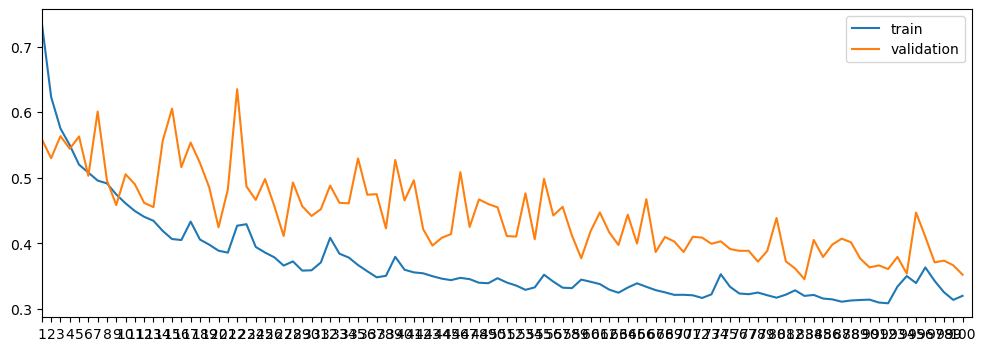

Epoch:100 Training Loss:0.3202128271902761 Validation Loss:0.35246419847748056: 100%|██████████| 100/100 [2:13:26<00:00, 80.06s/it]


In [42]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM240Flair.pt")

In [43]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MM240Flair.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4835080246300537
IOU: tensor(0.3859, device='cuda:0')
Precision: tensor(0.5311, device='cuda:0')
Recall: tensor(0.4948, device='cuda:0')
Accuracy: tensor(0.9992, device='cuda:0')


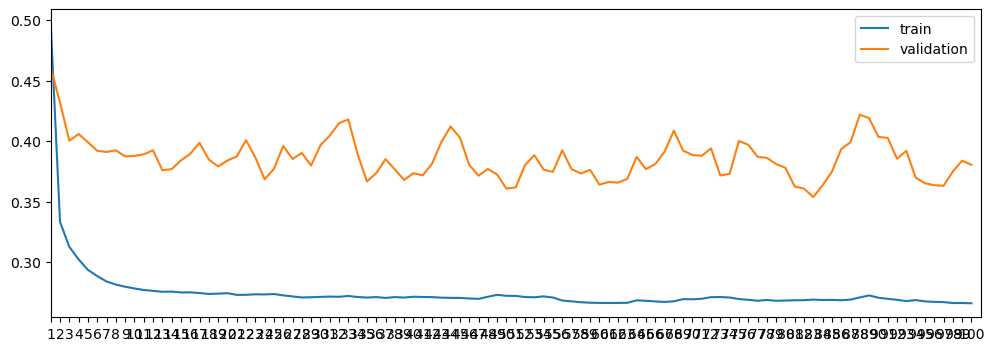

Epoch:100 Training Loss:0.2659680693380294 Validation Loss:0.3803600091879616: 100%|██████████| 100/100 [2:09:56<00:00, 77.97s/it]


In [60]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM240Flair05.pt")

In [61]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MM240Flair05.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4754889623773682
IOU: tensor(0.3785, device='cuda:0')
Precision: tensor(0.5391, device='cuda:0')
Recall: tensor(0.4737, device='cuda:0')
Accuracy: tensor(0.9992, device='cuda:0')


In [44]:
transform, transform_label=transform_normalization(240,False,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


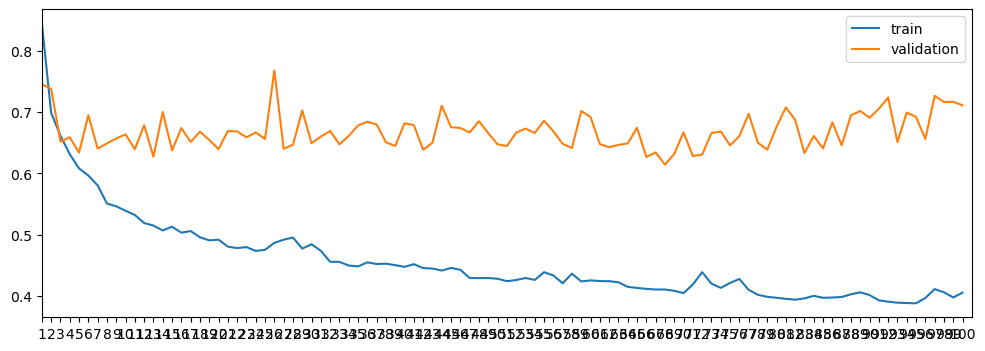

Epoch:100 Training Loss:0.4059330463409424 Validation Loss:0.7108434809714583: 100%|██████████| 100/100 [2:13:20<00:00, 80.01s/it]


In [45]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM240T1.pt")

In [46]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MM240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.24970002901727945
IOU: tensor(0.1769, device='cuda:0')
Precision: tensor(0.3332, device='cuda:0')
Recall: tensor(0.2313, device='cuda:0')
Accuracy: tensor(0.9987, device='cuda:0')


In [47]:
transform, transform_label=transform_normalization(240,False,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


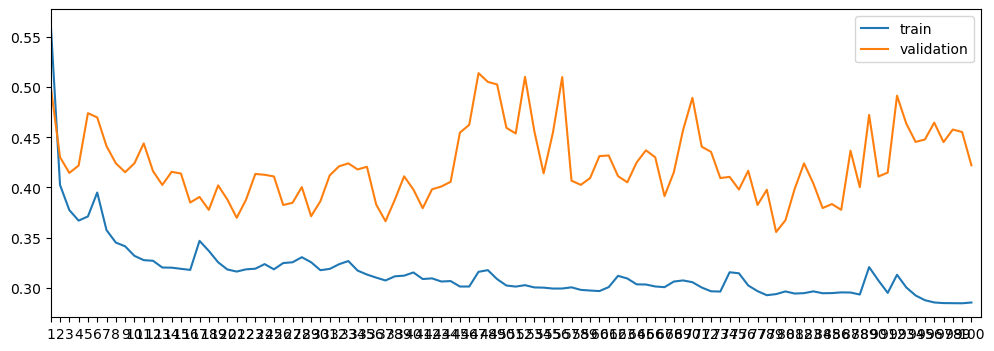

Epoch:100 Training Loss:0.28518663837063696 Validation Loss:0.4220479233907126: 100%|██████████| 100/100 [2:22:08<00:00, 85.29s/it]


In [48]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMmask240Flair.pt")

In [49]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMmask240Flair.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4794027659652035
IOU: tensor(0.3839, device='cuda:0')
Precision: tensor(0.5549, device='cuda:0')
Recall: tensor(0.4652, device='cuda:0')
Accuracy: tensor(0.9992, device='cuda:0')


In [50]:
transform, transform_label=transform_normalization(240,False,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


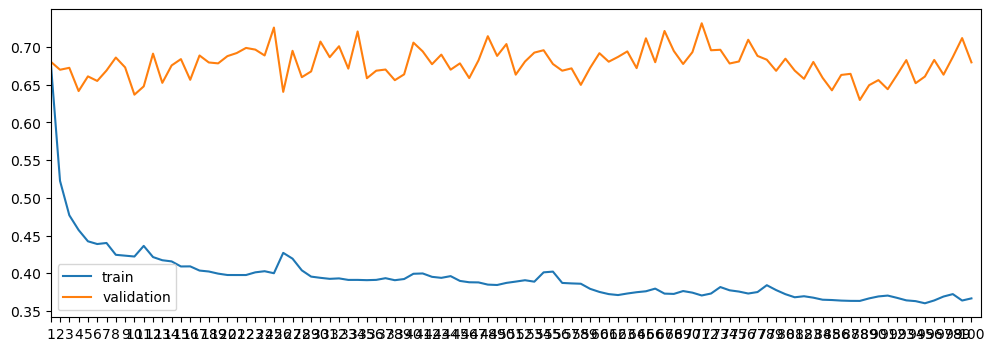

Epoch:100 Training Loss:0.36669225692749025 Validation Loss:0.6794510743744507: 100%|██████████| 100/100 [2:17:59<00:00, 82.80s/it]


In [51]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMmask240T1.pt")

In [52]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMmask240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2508897838320683
IOU: tensor(0.1755, device='cuda:0')
Precision: tensor(0.3769, device='cuda:0')
Recall: tensor(0.2221, device='cuda:0')
Accuracy: tensor(0.9987, device='cuda:0')


In [53]:
transform, transform_label=transform_normalization(240,False,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


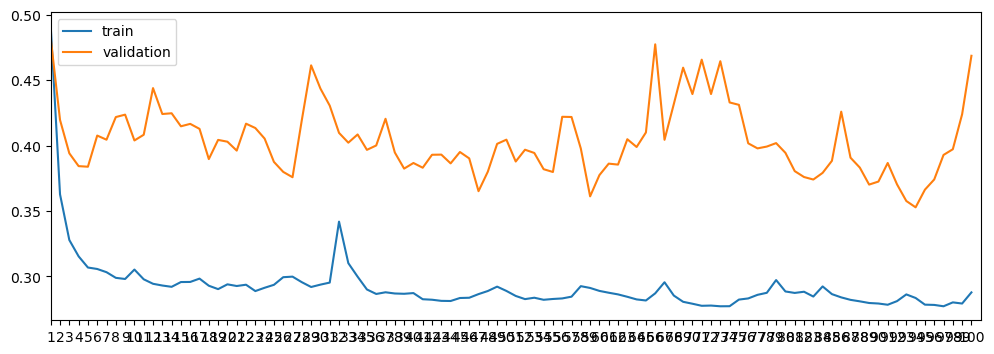

Epoch:100 Training Loss:0.2878286650103907 Validation Loss:0.4687799481968089: 100%|██████████| 100/100 [2:25:50<00:00, 87.50s/it]


In [54]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMFill240FLAIR.pt")

In [55]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMFill240FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.47800541944739394
IOU: tensor(0.3804, device='cuda:0')
Precision: tensor(0.5275, device='cuda:0')
Recall: tensor(0.4878, device='cuda:0')
Accuracy: tensor(0.9992, device='cuda:0')


In [56]:
transform, transform_label=transform_normalization(240,False,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


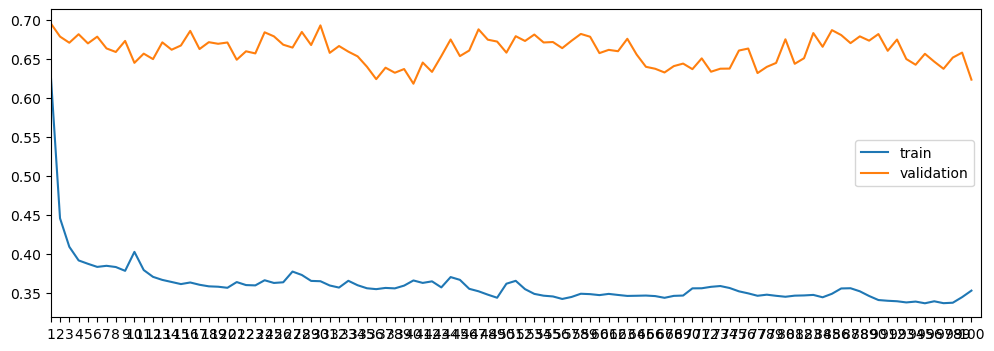

Epoch:100 Training Loss:0.35258320839174334 Validation Loss:0.623674099048147: 100%|██████████| 100/100 [2:26:25<00:00, 87.85s/it]


In [57]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMFill240T1.pt")

In [58]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMFill240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.23823125566265993
IOU: tensor(0.1657, device='cuda:0')
Precision: tensor(0.3569, device='cuda:0')
Recall: tensor(0.2100, device='cuda:0')
Accuracy: tensor(0.9987, device='cuda:0')


# Modelos con skull striping

# Modelos Con Concatenate

Se ha seleccionado inicialmente crop de 240 y normalizacion gaussian entera
1 T1 2 FLAIR 

In [62]:
transform, transform_label=transform_normalization(240,False,1)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,10)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


In [68]:
model = UNet(in_channels=2, out_channels=1, init_features=32)
model=model.to(device)

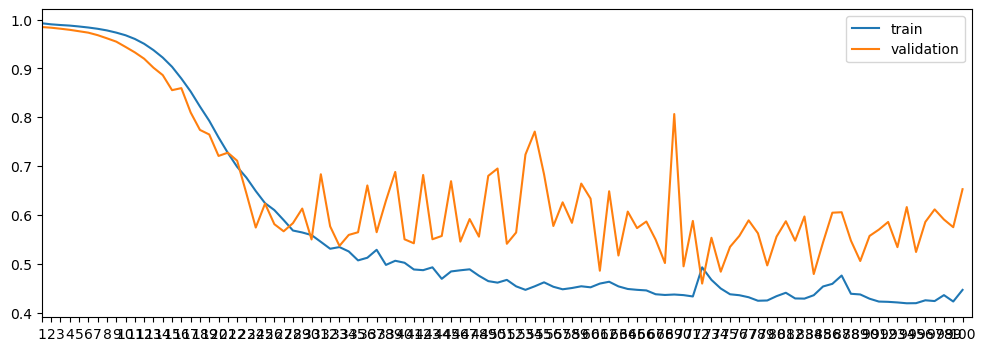

Epoch:100 Training Loss:0.4463474403681426 Validation Loss:0.6525675110641255: 100%|██████████| 100/100 [2:11:07<00:00, 78.68s/it]


In [64]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate.pt")

In [65]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4465816292275285
IOU: tensor(0.3497, device='cuda:0')
Precision: tensor(0.4571, device='cuda:0')
Recall: tensor(0.5040, device='cuda:0')
Accuracy: tensor(0.9991, device='cuda:0')


1 FLAIR 2 T1

In [77]:
transform, transform_label=transform_normalization(240,False,1)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


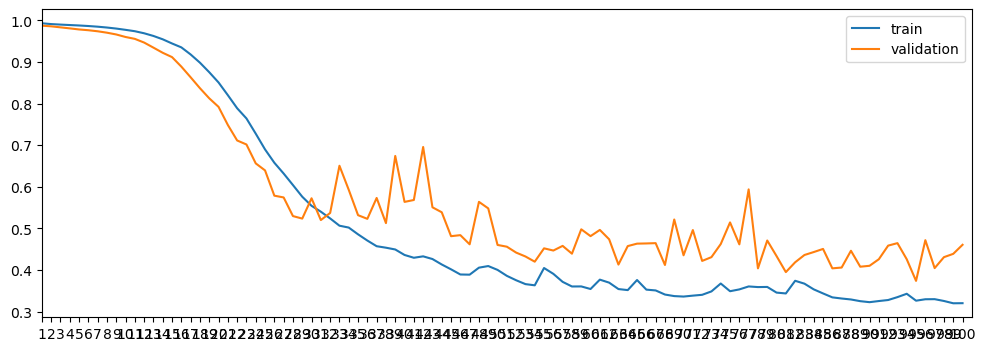

Epoch:100 Training Loss:0.32045054089638497 Validation Loss:0.4607130606807116: 100%|██████████| 100/100 [2:08:51<00:00, 77.32s/it]


In [69]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate2.pt")

In [78]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate2.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4787913285930887
IOU: tensor(0.3848, device='cuda:0')
Precision: tensor(0.5768, device='cuda:0')
Recall: tensor(0.4602, device='cuda:0')
Accuracy: tensor(0.9992, device='cuda:0')


MM 240 

In [70]:
model = UNet(in_channels=2, out_channels=1, init_features=32)
model=model.to(device)

In [71]:
transform, transform_label=transform_normalization(240,False,2)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,10)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


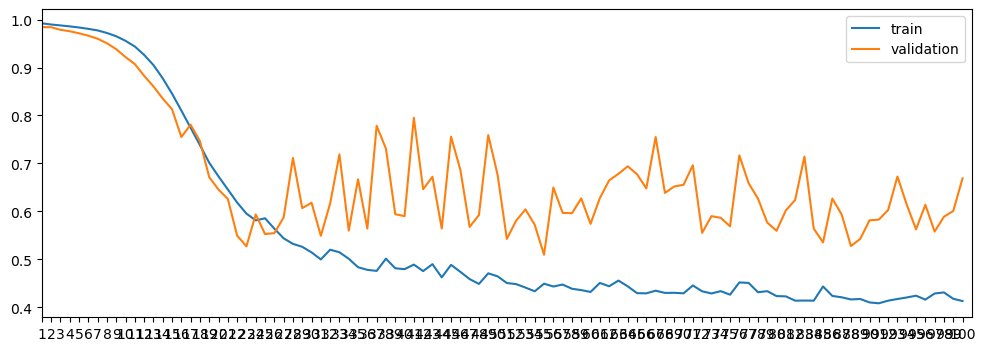

Epoch:100 Training Loss:0.4131298966962716 Validation Loss:0.6688438751792425: 100%|██████████| 100/100 [2:13:52<00:00, 80.32s/it]


In [72]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate3.pt")

In [73]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate3.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.4483504028776245
IOU: tensor(0.3512, device='cuda:0')
Precision: tensor(0.5250, device='cuda:0')
Recall: tensor(0.4580, device='cuda:0')
Accuracy: tensor(0.9991, device='cuda:0')


1: flair 2:t1

In [74]:
transform, transform_label=transform_normalization(240,False,2)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


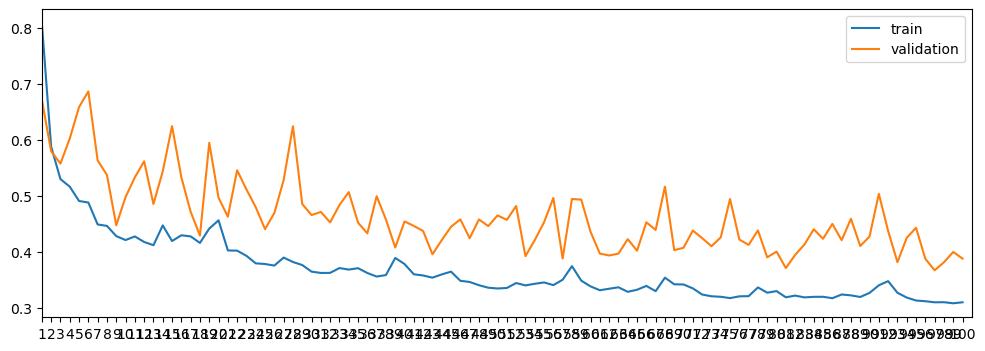

Epoch:100 Training Loss:0.30970353041925736 Validation Loss:0.38763805367167026: 100%|██████████| 100/100 [2:10:32<00:00, 78.32s/it]


In [75]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate4.pt")

In [76]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate4.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.47643646431632264
IOU: tensor(0.3831, device='cuda:0')
Precision: tensor(0.5487, device='cuda:0')
Recall: tensor(0.4714, device='cuda:0')
Accuracy: tensor(0.9992, device='cuda:0')


CAMBIAR LR

In [ ]:
model = UNet(in_channels=2, out_channels=1, init_features=32)
model=model.to(device)

In [ ]:
transform, transform_label=transform_normalization(200,False,1)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 100
optim = Adam(model.parameters(), lr=0.000035)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenatelr35.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenatelr35.pt")
calculate_metrics(model,test_dl, device)

AUMENTAR FEATURES

In [18]:
model = UNet(in_channels=2, out_channels=1, init_features=48)
model=model.to(device)

In [ ]:
transform, transform_label=transform_normalization(200,False,5) ???????
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

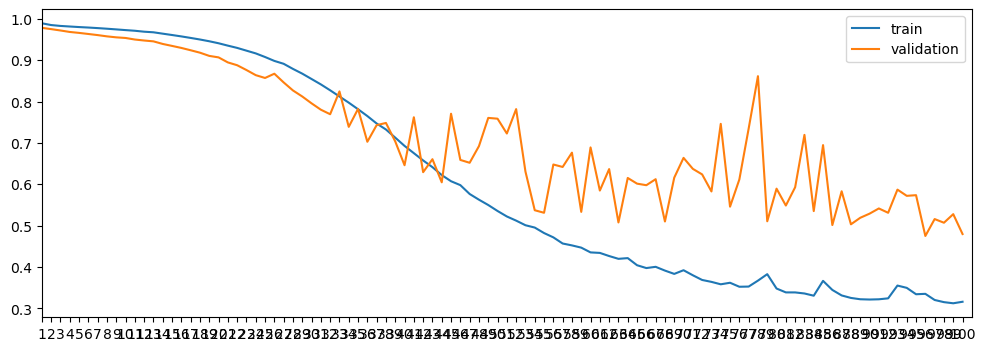

Epoch:100 Training Loss:0.31585907974550803 Validation Loss:0.4795849488497869: 100%|██████████| 100/100 [2:49:05<00:00, 101.45s/it]


In [19]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate5.pt")

In [20]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate5.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.191385708409239
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


DISMINUIR FEATURES

In [ ]:
model = UNet(in_channels=2, out_channels=1, init_features=24)
model=model.to(device)

In [33]:
transform, transform_label=transform_normalization(200,False,5)????
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


In [34]:
model = UNet(in_channels=2, out_channels=1, init_features=24, is200pad=True,is200crop=False)
model=model.to(device)

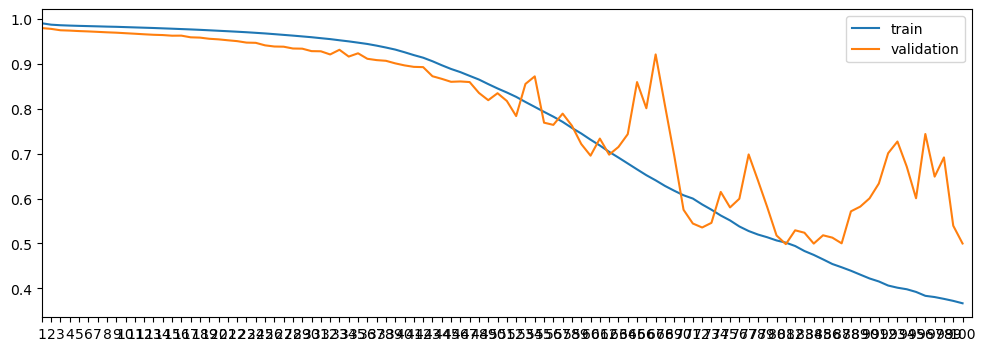

Epoch:100 Training Loss:0.3665787281528596 Validation Loss:0.49986682791980913: 100%|██████████| 100/100 [1:08:15<00:00, 40.96s/it]


In [19]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate6.pt")

In [20]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate6.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.2388294410995992
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


NUMERO DE EPOCAS

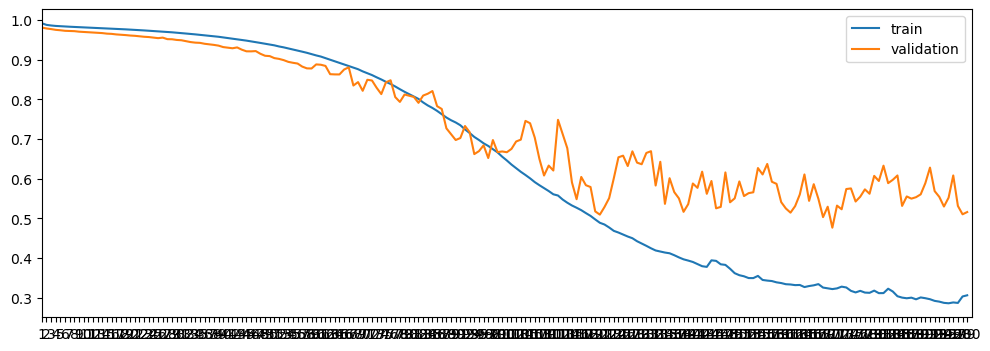

Epoch:200 Training Loss:0.30585549146898333 Validation Loss:0.5157658383288042: 100%|██████████| 200/200 [2:20:42<00:00, 42.21s/it]


In [35]:
epochs = 200
optim = Adam(model.parameters(), lr=0.000035)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenatelr35200.pt")

In [36]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenatelr35200.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2386824700858836
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [21]:
model = UNet(in_channels=2, out_channels=1, init_features=28 
model=model.to(device)

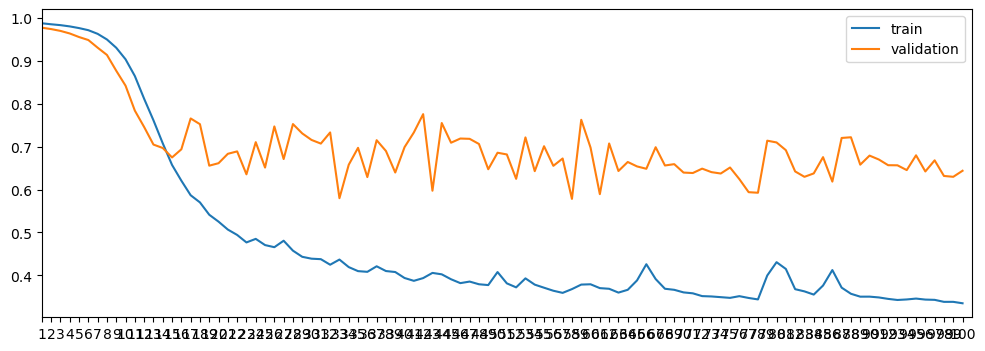

Epoch:100 Training Loss:0.33467684253569574 Validation Loss:0.6440009159885224: 100%|██████████| 100/100 [1:21:25<00:00, 48.85s/it]


In [23]:
epochs = 50
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenate7.pt")

In [24]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenate7.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.11130156785917567
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


SHUFFLED

In [41]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,True,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


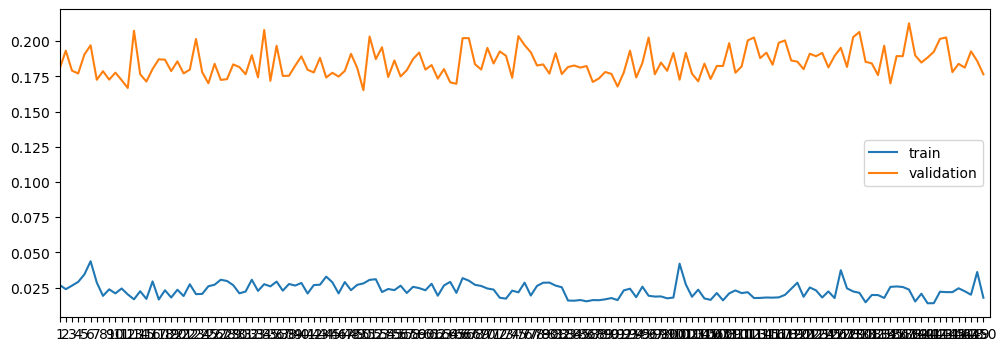

Epoch:150 Training Loss:0.01788729198517338 Validation Loss:0.17638464077147123: 100%|██████████| 150/150 [1:46:14<00:00, 42.50s/it]


In [45]:
epochs = 150
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Concatenateshuffled.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Concatenateshuffled.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.26161049787004137
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


# Data Augmentation

- Rotation (-15,15)
- Scale (0.9,1.1)
- Shearing(-18,18)


(-0.5, 255.5, 131.5, -0.5)

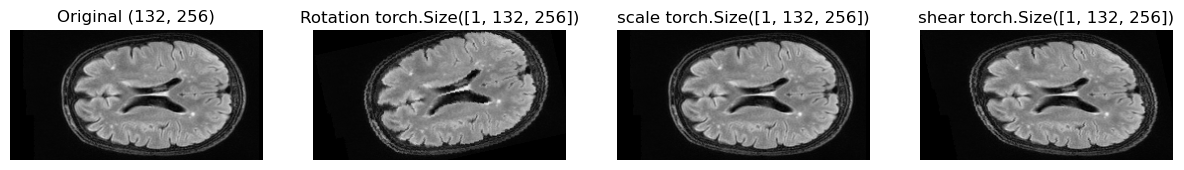

In [34]:
fig,axs = plt.subplots(1, 4, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_rot,_=dataAugmentation(image_data[:, :, 53],image_data[:, :, 53],(-15,15),None,None)
axs[1].imshow(image_rot.squeeze(0), cmap='gray')
axs[1].set_title("Rotation %s" %(image_rot.shape,))
axs[1].axis('off')

image_scale,_=dataAugmentation(image_data[:, :, 53],image_data[:, :, 53],(0,0),(0.9,1.1),None)
axs[2].imshow(image_scale.squeeze(0), cmap='gray')
axs[2].set_title("scale %s" %(image_scale.shape,))
axs[2].axis('off')

image_she,_=dataAugmentation(image_data[:, :, 53],image_data[:, :, 53],(0,0),None,(-18,18))
axs[3].imshow(image_she.squeeze(0), cmap='gray')
axs[3].set_title("shear %s" %(image_she.shape,))
axs[3].axis('off')

(-0.5, 255.5, 131.5, -0.5)

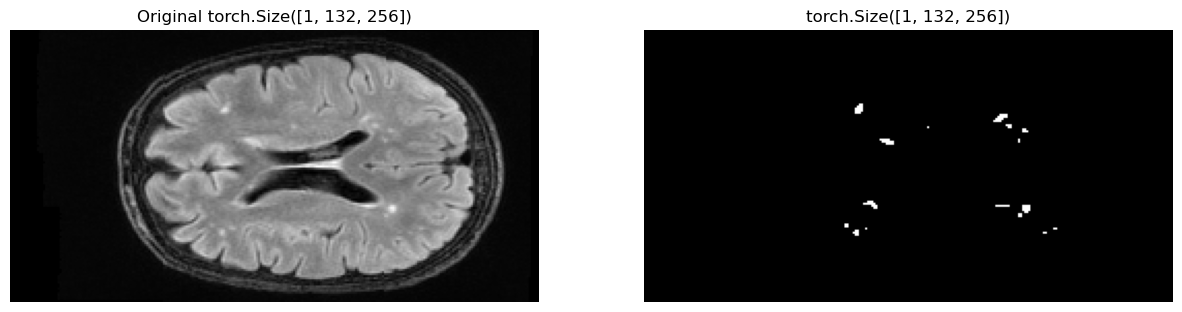

In [35]:
fig,axs = plt.subplots(1, 2, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
flairData=image_data[:, :,53]

mask= os.path.join(TRAINING_PATH_AMSTERDAM, "100","wmh.nii.gz")
img = nibabel.load(mask)
image_data = img.get_fdata() 
maskData=image_data[:, :,53]
flairData,maskData = dataAugmentation(flairData,maskData,(-15,15), None, None)
axs[0].imshow(flairData.squeeze(0), cmap='gray')
axs[0].set_title("Original %s" %(flairData.shape,))
axs[0].axis('off')


axs[1].imshow(maskData.squeeze(0), cmap='gray')
axs[1].set_title("%s" %(maskData.shape,))
axs[1].axis('off')

- 200 CROP
- GAUSSIAN NORMALIZATION FILL
- FEATURES 24
- 100-150 epochs

In [11]:
model = UNet(in_channels=2, out_channels=1, init_features=24, is200pad=True,is200crop=False)
model=model.to(device)

In [30]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:128: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


In [31]:
images, masks = generateAugmentation(train_data,5)
print(len(images))
print(len(masks))
images2= [torch.as_tensor(arr) for arr in train_data.images]
masks2= [torch.as_tensor(arr) for arr in train_data.masks]

images += images2
masks += masks2
train_data = Augmentation(images, masks)
print(len(train_data))
train_dl = DataLoader(train_data, batch_size=15, shuffle=False)

5
5
2316


In [33]:
print("Type of images:", type(images[0]))
print("Type of masks:", type(masks[0]))
print("Type of images:", type(train_data.images[0]))
print("Type of masks:", type(train_data.masks[0]))
print(images[0].shape)

Type of images: <class 'torch.Tensor'>
Type of masks: <class 'torch.Tensor'>
Type of images: <class 'torch.Tensor'>
Type of masks: <class 'torch.Tensor'>
torch.Size([200, 2, 200])


In [ ]:
print(len(train_data.masks))

5


In [32]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/DATA_AUGMENTATION/DA1000.pt")

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [200, 2, 200] at entry 0 and [2, 200, 200] at entry 5

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/DATA_AUGMENTATION/DA1000.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)
images, masks = generateAugmentation(train_data,2000)
train_data2 = Augmentation(images, masks)
train_data = ConcatDataset([train_data,train_data2])
train_dl = DataLoader(train_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/DATA_AUGMENTATION/DA2000.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/DATA_AUGMENTATION/DA2000.pt")
calculate_metrics(model,test_dl, device)

In [52]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)
images, masks = generateAugmentation(train_data,3000)
train_data2 = Augmentation(images, masks)
train_data = ConcatDataset([train_data,train_data2])
train_dl = DataLoader(train_data, batch_size=15, shuffle=False)

2311
514


c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:128: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


IndexError: list index out of range

In [ ]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/DATA_AUGMENTATION/DA3000.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/DATA_AUGMENTATION/DA3000.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)
images, masks = generateAugmentation(train_data,4000)
train_data2 = Augmentation(images, masks)
train_data = ConcatDataset([train_data,train_data2])
train_dl = DataLoader(train_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/DATA_AUGMENTATION/DA4000.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/DATA_AUGMENTATION/DA4000.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsT1","pathsFLAIR",train,val,transform, transform_label,False,15)
test_data=Concatenate(TEST_DICT.get("pathsT1"),TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)
images, masks = generateAugmentation(train_data,5000)
train_data2 = Augmentation(images, masks)
train_data = ConcatDataset([train_data,train_data2])
train_dl = DataLoader(train_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 100
optim = Adam(model.parameters(), lr=0.00005)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/DATA_AUGMENTATION/DA5000.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/DATA_AUGMENTATION/DA5000.pt")
calculate_metrics(model,test_dl, device)